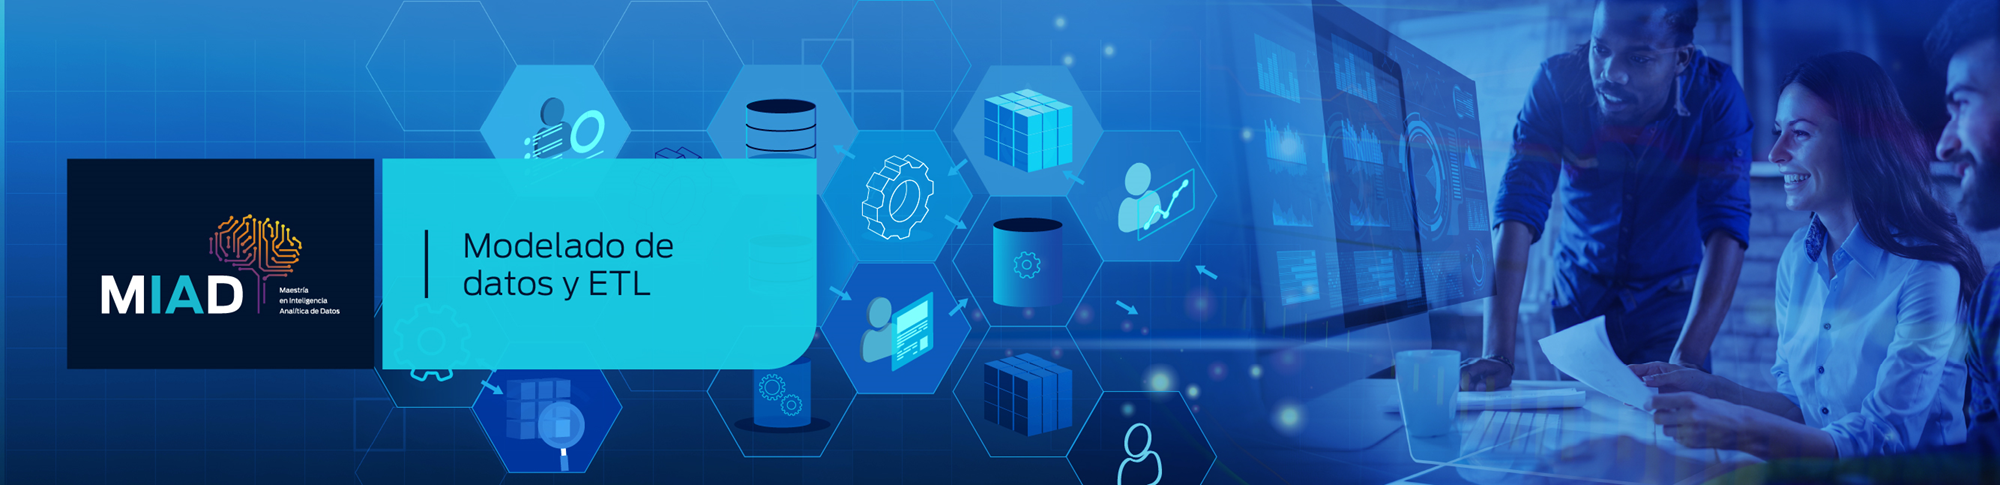

# Actividad: Implementar un proceso ETL (P)

## Modelo multidimensional

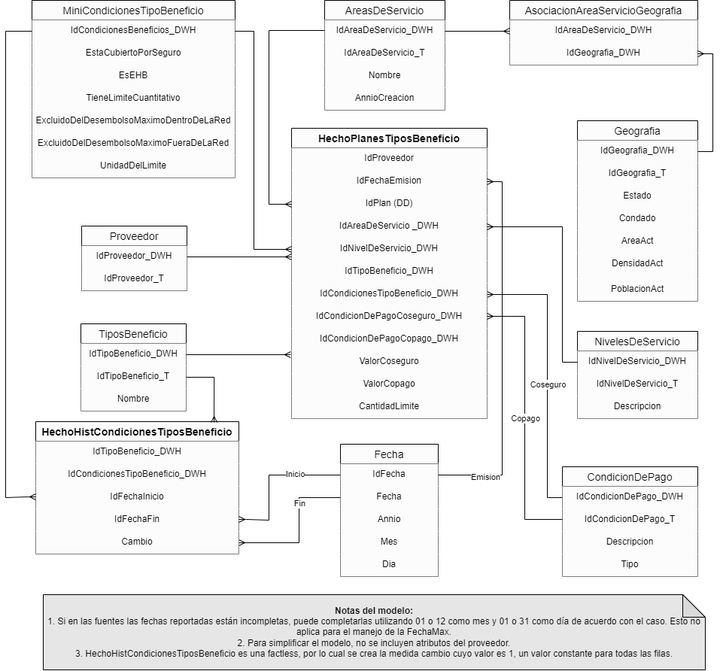

## Datos suministrados

Los datos los puede encontrar en la base de datos: RasaTransaccional_ETL. También puede encontrar el diccionario de los mismos aquí, ambos recursos requeridos para el desarrollo de esta tarea. Las tablas son copias de las tablas fuente del proceso que se está analizando. Recuerde que los datos que se usaron para el entendimiento de datos tienen como sufijo Copia (e.g., BeneficiosCopia), en caso de que deseen repasar o rehacer el ejercicio de Entendimiento de datos. Los datos revisados por RaSA a partir de los resultados y/o conclusiones que obtuvieron en la etapa de entenimiento de datos y que deben ser utilizados en el proceso de ETL quedan en las tablas:

* F1: **GruposAreasdeServicio** y AreasDeServicio
* F2: Beneficios
* F3: BeneficiosPlanes
* F4: **NivelDeRed** y CondicionesDePago

En el proceso de carga, para manejar atributos tipo fecha, si el atributo no tiene día o mes, asuma como valores por defecto el primer día del mes, y el primer mes de cada año.

**Observaciones:** 
La fuente mencionada RasaTransaccional_ETL contiene cuatro tablas:
> 1. FuenteAreasDeServicio_ETL
> 2. FuenteCondicionesDePago_ETL
> 3. FuentePlanesBeneficio_ETL
> 4. FuenteTiposBeneficio_ETL
> 5. NivelesDeServicio

Respecto a los datos mencionados no existe información de **GruposAreasdeServicio**, ni de **NivelDeRed**. Asumimos que Beneficios se refierea TiposBeneficio, y BeneficiosPlanes a PlanesBeneficio. 

## Respuestas del negocio a conclusiones de Entendimiento

Después de hacer una revisión a las fuentes que fueron inicialmente proporcionadas, gracias a sus comentarios y preguntas, encontramos los siguientes errores relacionados con las reglas de negocio que les compartimos:

1. Las áreas de servicio NO cubren todos los condados del país.
2. No fue posible validar la condición de límites cuantitativos, así que, si se evidencia límites cuantitativos sin valor o con un valor en cero, en los planes que los ofrecen, debe colocar como valor por defecto 333 para poder identificar el error y corregirlo en el futuro.
3. Se corrigió la fecha de 1800 que estaba en la fuente de áreas de servicio.
4. La fuente de áreas de servicio tenía información solo de los años 2017 y 2018 y faltaba todo el año 2019.
5. En la fuente de tipos de beneficios no deberían existir diferentes condiciones y unidad de límite para el mismo tipo de beneficio en el mismo año. Esto fue arreglado y solo debe existir un valor de condiciones y unidad límite de tipo de beneficio por año.
6. El valor máximo Copago y Coseguro para el año 2018 es 3500 y 100 respectivamente.
7. En la fuente de condiciones de pago se eliminaron los registros con el mismo tipo y descripción que tenía diferentes identificadores.

RaSa también le comenta que:

En la fuente de tipos de beneficio:
* a. Se corrigieron los registros con diferentes unidades de límites para el mismo beneficio en el mismo año. 
* b. Sin embargo, siguen existiendo errores de consistencia en los valores de las condiciones, se le pide cambiar los diferentes valores para que queden únicamente “Yes” y “No”.

En la fuente de áreas de servicio 
* a. Se eliminaron los registros con diferentes IdGeografia cuyo contenido en los demás atributos era el mismo. 
* b. Se corrigieron los registros con IdAreaDeServicio e IdGeografia nulos. 
* c. Las fechas erróneas fueron actualizadas por las correctas. 
* d. Se le pide corregir los registros con áreas negativas, multiplicando por -1 esos valores. 
* e. Finalmente, los que presentan un error de digitación en la población actual con 3 ceros y un uno al final del número (0001) debe corregirlos y quitarles estos últimos 4 dígitos, de tal forma que si el valor era 27540001 debe quedar 2754.

En la fuente de condiciones de pago 
* a. Se actualizaron los registros con tipo NaN 
* b. Sin embargo, siguen existiendo errores de consistencia, se le pide corregir el tipo a solo Copago y Coseguro.

En la fuente de planes beneficio:
* a. Se corrigieron los registros que tenían valores nulos en IdPlan, IdTipoBeneficio o IdAreaDeServicio.
* b. Se eliminaron los registros con IdTipoBeneficio que no estaban en la fuente de Tipos de Beneficios. Sin embargo, todavía existen IdAreaDeServicio que no están presentes en la fuente correspondiente, por lo que se le recomienda crear un registro de desconocido (Identificador=0) y NO omitir esta información en el proceso de carga. 
* c. Finalmente, las fechas inválidas fueron actualizadas, pero todavía existen fechas con otro tipo de formato y se le pide que las transforme para que todas queden con formato YYYY-MM-DD.


Puede que existan todavía duplicados de los registros en las fuentes, por favor revisar y eliminarlos.

Estaremos atentos si quedaron preguntas sin contestar para hacerlo en la menor brevedad.

# Fase 0. Preliminares
## Importacion de paquetes, configuración e inicio de sesión en MySQL y Spark

### Se importan los paquetes de python necesarios

In [1]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mysql.connector

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, abs as pysAbs, min as pysMin, max as pysMax, sum as pysSum
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql import types as t
#from pandas_profiling import ProfileReport
#from IPython.display import HTML
from pyspark.sql import Row
from pyspark.sql.window import Window

### Configuración del controlador e inicio de sesion MySQL

In [3]:
# Credenciales
db_user = 'Estudiante_15_202413'
db_psswd = 'aabb1122'
host = "157.253.236.120"
port ="8080"

database1 = "RaSaTransaccional_ETL"
database2 = "Proyecto_G1_202413"

# Establecer la conexión a la base de datos 
DB_work = mysql.connector.connect(
        host=host,
        port=port,
        user=db_user,
        password=db_psswd,
        database=database2
        )
workDB = DB_work.cursor()

def refrescar_conexion(conn, host, port, user, password, database):
    if conn.is_connected():
        conn.close()
    
    conn = mysql.connector.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=database
    )
    cursor = conn.cursor()
    return conn, cursor

### Configuración del controlador e inicio de sesion Spark

In [4]:
# asegurar que todos los componentes de Spark utilicen el mismo intérprete de Python que se esta ejecutando en el notebook
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'
#path_jar_driver = 'C:\Program Files\MySQL\MySQL Workbench 8.0 CE\Connector J 8.0\mysql-connector-j-8.3.0.jar'
#path_jar_driver = 'C:\Program Files\MySQL\MySQL Workbench 8.0 CE\Connector J 8.0\mysql-connector-java-8.0.28.jar'
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

# esta linea permite a spark utlizar e l parser de tiempo anterior a al versión 3.0, y evita un problema con el análisis de fecha y hora
# Exception: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2015-12-02 12:00:00.0000000' in the new parser.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") 

# Conexion con el servidor de base de datos:
#db_connection_string = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'
source_db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional_ETL'
dest_db_connection_string = 'jdbc:mysql://157.253.236.120:8080/Proyecto_G1_202413?autoReconnect=true'

# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_15_202413'
db_psswd = 'aabb1122'

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('batchsize', 10000) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

# Fase 1. Creación de tablas
## Crear y guardar sentencias SQL

In [6]:
# Se incluye un grupo de sentencia para verificar si la tabla existe, y si existe eliminarla. 
# Lo anterior con el fin de evitar errores si la tabla se creo en ejercicios previos, 
# también para evitar crecer el tamaño de la base de datos

# Sentencias par eliminar tablas
drop_table_queries = [
    "DROP TABLE IF EXISTS HechoPlanesTipoBeneficio;",
    "DROP TABLE IF EXISTS HechoHistCondicionesTiposBeneficio;",
    "DROP TABLE IF EXISTS Fecha;",
    "DROP TABLE IF EXISTS AsociacionAreaServicioGeografia;",
    "DROP TABLE IF EXISTS AreasDeServicio;",
    "DROP TABLE IF EXISTS Geografia;",
    "DROP TABLE IF EXISTS TiposBeneficio;",
    "DROP TABLE IF EXISTS NivelesDeServicio;",
    "DROP TABLE IF EXISTS CondicionDePago;",
    "DROP TABLE IF EXISTS Proveedor;",
    "DROP TABLE IF EXISTS MiniCondicionesTipoBeneficio;",
    
    
]

# Sentencias para crear las tablas
create_table_queries = [
    """
    CREATE TABLE Fecha (
        IdFecha INT NOT NULL,
        Fecha DATE, 
        Dia TINYINT,  
        Mes SMALLINT,
        Annio SMALLINT,
        PRIMARY KEY(IdFecha)
    );
    """,
    """
    CREATE TABLE Proveedor(
        IdProveedor_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdProveedor_T INT NOT NULL
    );
    """,
    """
    CREATE TABLE NivelesDeServicio(
        IdNivelServicio_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdNivelDeServicio_T INT NOT NULL,  
        Descripcion VARCHAR(50)
    );
    """,
    """
    CREATE TABLE CondicionDePago(
        IdCondicionDePago_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdCondicionDePago_T INT NOT NULL,  
        Descripcion VARCHAR(50),
        Tipo VARCHAR(50)
    );
    """,
    """
    CREATE TABLE Geografia (
        IdGeografia_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdGeografia_T INT NOT NULL, 
        Estado VARCHAR(50),
        Condado VARCHAR(50),
        AreaAct FLOAT, 
        DensidadAct FLOAT, 
        PoblacionAct FLOAT
    );
    """,
    """
    CREATE TABLE AreasDeServicio (
        IdAreaDeServicio_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdAreaDeServicio_T  INT NOT NULL, 
        Nombre VARCHAR(100),
        AnnioCreacion INT
    );
    """,
    """
    CREATE TABLE AsociacionAreaServicioGeografia(
        IdAreaDeServicio_DWH INT NOT NULL,
        IdGeografia_DWH INT NOT NULL
    );
        
    """,
    """
    CREATE TABLE TiposBeneficio (
        IdTipoBeneficio_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdTipoBeneficio_T INT NOT NULL, 
        Nombre VARCHAR(100)
    );
    """,
     """
    CREATE TABLE MiniCondicionesTipoBeneficio (
        IdCondicionesTipoBeneficio_DWH INT AUTO_INCREMENT PRIMARY KEY,
        UnidadDelLimite VARCHAR(50),
        EsEHB VARCHAR(3),
        EstaCubiertoPorSeguro VARCHAR(3),
        TieneLimiteCuantitativo VARCHAR(3),
        ExcluidoDelDesembolsoMaximoDentroDeLaRed VARCHAR(3),
        ExcluidoDelDesembolsoMaximoFueraDeLaRed VARCHAR(3)
    );
    """,
    """
    CREATE TABLE HechoHistCondicionesTiposBeneficio (
        IdTipoBeneficio_DWH INT, 
        IdCondicionesTipoBeneficio_DWH INT,
        IdFechaInicio INT, 
        IdFechaFin INT,
        Cambio INT       
    );
    """,
    """
    CREATE TABLE HechoPlanesTipoBeneficio (
        IdProveedor_DWH INT, 
        IdFechaEmision INT, 
        IdPlanDD VARCHAR(100) NOT NULL,
        IdTipoBeneficio_DWH INT NOT NULL, 
        IdAreaDeServicio_DWH INT NOT NULL, 
        IdCondicionDePagoCopago_DWH INT NOT NULL, 
        IdCondicionDePagoCoseguro_DWH INT NOT NULL, 
        IdNivelServicio_DWH INT NOT NULL, 
        IdCondicionesTipoBeneficio_DWH INT NOT NULL,
        ValorCopago INT, 
        ValorCoseguro INT,
        CantidadLimite INT
    );
    """
]

# Sentencias para agregar claves foráneas a la tabla de hechos
alter_table_query = ["""
ALTER TABLE HechoPlanesTipoBeneficio
    ADD CONSTRAINT fk_fecha
    FOREIGN KEY (IdFechaEmision) REFERENCES Fecha(IdFecha),
    ADD CONSTRAINT fk_TipoBeneficio
    FOREIGN KEY (IdTipoBeneficio_DWH) REFERENCES TiposBeneficio(IdTipoBeneficio_DWH),
    ADD CONSTRAINT fk_CondicionDePagoCopago
    FOREIGN KEY (IdCondicionDePagoCopago_DWH) REFERENCES CondicionDePago(IdCondicionDePago_DWH),
    ADD CONSTRAINT fk_CondicionDePagoCoseguro
    FOREIGN KEY (IdCondicionDePagoCoseguro_DWH) REFERENCES CondicionDePago(IdCondicionDePago_DWH),
    ADD CONSTRAINT fk_AreaServicio
    FOREIGN KEY (IdAreaDeServicio_DWH) REFERENCES AreasDeServicio(IdAreaDeServicio_DWH),
    ADD CONSTRAINT fk_NivelServicio
    FOREIGN KEY (IdNivelServicio_DWH) REFERENCES NivelesDeServicio(IdNivelServicio_DWH),
    ADD CONSTRAINT fk_Proveedor
    FOREIGN KEY (IdProveedor_DWH) REFERENCES Proveedor(IdProveedor_DWH),
    ADD CONSTRAINT fk_MiniCondiciones
    FOREIGN KEY (IdCondicionesTipoBeneficio_DWH) REFERENCES MiniCondicionesTipoBeneficio(IdCondicionesTipoBeneficio_DWH);
""",
"""
ALTER TABLE AsociacionAreaServicioGeografia
    ADD CONSTRAINT fk_areaServicio2
    FOREIGN KEY (IdAreaDeServicio_DWH) REFERENCES AreasDeServicio(IdAreaDeServicio_DWH),
    ADD CONSTRAINT fk_geografia
    FOREIGN KEY (IdGeografia_DWH) REFERENCES Geografia(IdGeografia_DWH);
""",
"""
ALTER TABLE HechoHistCondicionesTiposBeneficio
    ADD CONSTRAINT fk_fechaInicio
    FOREIGN KEY (IdFechaInicio) REFERENCES Fecha(IdFecha),
    ADD CONSTRAINT fk_fechaFin
    FOREIGN KEY (IdFechaFin) REFERENCES Fecha(IdFecha),
    ADD CONSTRAINT fk_tipoBeneficio2
    FOREIGN KEY (IdTipoBeneficio_DWH) REFERENCES TiposBeneficio(IdTipoBeneficio_DWH),
    ADD CONSTRAINT fk_MiniCondiciones2
    FOREIGN KEY (IdCondicionesTipoBeneficio_DWH) REFERENCES MiniCondicionesTipoBeneficio(IdCondicionesTipoBeneficio_DWH);
""",
]

**Observaciones:** Se crean las instrucciones para la creación de las tablas del modelo multidimensional y se almacenan en las listas de trabajo 'drop_table_queries' y 'create_table_queries'. Las claves foraneas de la tabla de hechos se agregan despuúes de su creación utilizando el método 'ALTER TABLE', la instrucción completa se guarda en la variable 'alter_table_query' para su posterior ejecución.

## Verificar si existen tablas en la base de datos de trabajo

In [7]:
# Ver listado de tablas existentes
workDB.execute("SHOW TABLES")
tables = workDB.fetchall()
n_tables = len(tables)

if n_tables == 0:
    print("No se encontraron tablas en la base de datos de trabajo.")
else:
    print("Tablas en la base de datos de trabajo:")
    for table in tables:
        print(table[0])

Tablas en la base de datos de trabajo:
AreasDeServicio
AsociacionAreaServicioGeografia
CondicionDePago
Fecha
Geografia
HechoHistCondicionesTiposBeneficio
HechoPlanesTipoBeneficio
MiniCondicionesTipoBeneficio
NivelesDeServicio
Proveedor
TiposBeneficio


## Elimnar las tablas existentes cuyo nombre coincide con las que se van a crear

In [8]:
# Eliminar tablas
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

if n_tables !=0:
    for query in drop_table_queries:
        print(query)
        workDB.execute(query)
        #DB_work.commit()
    print("Se eliminaron las tablas en la base de datos de trabajo")
    

DROP TABLE IF EXISTS HechoPlanesTipoBeneficio;
DROP TABLE IF EXISTS HechoHistCondicionesTiposBeneficio;
DROP TABLE IF EXISTS Fecha;
DROP TABLE IF EXISTS AsociacionAreaServicioGeografia;
DROP TABLE IF EXISTS AreasDeServicio;
DROP TABLE IF EXISTS Geografia;
DROP TABLE IF EXISTS TiposBeneficio;
DROP TABLE IF EXISTS NivelesDeServicio;
DROP TABLE IF EXISTS CondicionDePago;
DROP TABLE IF EXISTS Proveedor;
DROP TABLE IF EXISTS MiniCondicionesTipoBeneficio;
Se eliminaron las tablas en la base de datos de trabajo


## Crear las tablas del modelo de RaSa

In [9]:
# Crear las tablas
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)
for query in create_table_queries:
    print(query)
    workDB.execute(query)
    DB_work.commit()
print("Se crearon las tablas en la base de datos de trabajo")


    CREATE TABLE Fecha (
        IdFecha INT NOT NULL,
        Fecha DATE, 
        Dia TINYINT,  
        Mes SMALLINT,
        Annio SMALLINT,
        PRIMARY KEY(IdFecha)
    );
    

    CREATE TABLE Proveedor(
        IdProveedor_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdProveedor_T INT NOT NULL
    );
    

    CREATE TABLE NivelesDeServicio(
        IdNivelServicio_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdNivelDeServicio_T INT NOT NULL,  
        Descripcion VARCHAR(50)
    );
    

    CREATE TABLE CondicionDePago(
        IdCondicionDePago_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdCondicionDePago_T INT NOT NULL,  
        Descripcion VARCHAR(50),
        Tipo VARCHAR(50)
    );
    

    CREATE TABLE Geografia (
        IdGeografia_DWH INT AUTO_INCREMENT PRIMARY KEY,
        IdGeografia_T INT NOT NULL, 
        Estado VARCHAR(50),
        Condado VARCHAR(50),
        AreaAct FLOAT, 
        DensidadAct FLOAT, 
        PoblacionAct FLOAT
    );
    

    CREATE TA

In [10]:
# Agragar claves foraneas a la tabla de hechos
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

for query in alter_table_query:
    print(query)
    workDB.execute(query)
    DB_work.commit()

print("Se agregaron las claves foráneas a las tablas del modelo")



ALTER TABLE HechoPlanesTipoBeneficio
    ADD CONSTRAINT fk_fecha
    FOREIGN KEY (IdFechaEmision) REFERENCES Fecha(IdFecha),
    ADD CONSTRAINT fk_TipoBeneficio
    FOREIGN KEY (IdTipoBeneficio_DWH) REFERENCES TiposBeneficio(IdTipoBeneficio_DWH),
    ADD CONSTRAINT fk_CondicionDePagoCopago
    FOREIGN KEY (IdCondicionDePagoCopago_DWH) REFERENCES CondicionDePago(IdCondicionDePago_DWH),
    ADD CONSTRAINT fk_CondicionDePagoCoseguro
    FOREIGN KEY (IdCondicionDePagoCoseguro_DWH) REFERENCES CondicionDePago(IdCondicionDePago_DWH),
    ADD CONSTRAINT fk_AreaServicio
    FOREIGN KEY (IdAreaDeServicio_DWH) REFERENCES AreasDeServicio(IdAreaDeServicio_DWH),
    ADD CONSTRAINT fk_NivelServicio
    FOREIGN KEY (IdNivelServicio_DWH) REFERENCES NivelesDeServicio(IdNivelServicio_DWH),
    ADD CONSTRAINT fk_Proveedor
    FOREIGN KEY (IdProveedor_DWH) REFERENCES Proveedor(IdProveedor_DWH),
    ADD CONSTRAINT fk_MiniCondiciones
    FOREIGN KEY (IdCondicionesTipoBeneficio_DWH) REFERENCES MiniCondicione

## Verificar que las tablas han sido creadas y que el esquema correponde con los solicitado

In [11]:
# Verificar que las tablas han sido creadas
workDB.execute("SHOW TABLES")
tables = workDB.fetchall()
n_tables = len(tables)

if n_tables == 0:
    print("No se encontraron tablas en la base de datos de trabajo.")
else:
    print("Tablas en la base de datos de trabajo:")
    for table in tables:
        print("|-- ",table[0])

Tablas en la base de datos de trabajo:
|--  AreasDeServicio
|--  AsociacionAreaServicioGeografia
|--  CondicionDePago
|--  Fecha
|--  Geografia
|--  HechoHistCondicionesTiposBeneficio
|--  HechoPlanesTipoBeneficio
|--  MiniCondicionesTipoBeneficio
|--  NivelesDeServicio
|--  Proveedor
|--  TiposBeneficio


In [12]:
for table in tables:
    describe_table = f'DESCRIBE {table[0]}'
    workDB.execute(describe_table)
    schema = workDB.fetchall()
    print(f"Schema de la tabla '{table[0]}':")
    print(f"{'Field':<50} {'Type':<20} {'Null':<5} {'Key':<5} {'Default':<10} {'Extra':<15}")
    print("-" * 120)
    for column in schema:
        field, type_, null, key, default, extra = column
        default_str = default if default is not None else 'NULL'
        type_str = type_.decode('utf-8') if isinstance(type_, bytes) else type_
        print(f"{field:<50} {type_str:<20} {null:<5} {key:<5} {default_str:<10} {extra:<15}")
    print()

Schema de la tabla 'AreasDeServicio':
Field                                              Type                 Null  Key   Default    Extra          
------------------------------------------------------------------------------------------------------------------------
IdAreaDeServicio_DWH                               int                  NO    PRI   NULL       auto_increment 
IdAreaDeServicio_T                                 int                  NO          NULL                      
Nombre                                             varchar(100)         YES         NULL                      
AnnioCreacion                                      int                  YES         NULL                      

Schema de la tabla 'AsociacionAreaServicioGeografia':
Field                                              Type                 Null  Key   Default    Extra          
------------------------------------------------------------------------------------------------------------------------

**Observaciones:** Se configura e inicia sesión en el servidor de MySQL. Se verifica si existen tablas en la base de datos de trabajo: 'Proyecto_G1_202413', las tablas con un nombre igual a las que se van a crear son eliminadas. Se ejecutan las sentencias de creación de tablas definidas con anterioridad; y se listan de nuevo las tablas existentes en la base de datos, confirmando que han sido creadas. Se consulta e imprime el esquema de cada una de las tablas creadas, encontrando que la creación es correcta y conforme a la instrucción dada.

# Fase 2 Transformación de datos

## Dimensión. CondicionesDePago. 

### Extracción

#### F1. RaSaTransaccional_ETL.FuenteCondicionesDePago_ETL

In [13]:
sql_ = '''(SELECT IdCondicionesDePago_T AS IdCondicionDePago_T, Descripcion, Tipo FROM RaSaTransaccional_ETL.FuenteCondicionesDePago_ETL ORDER BY IdCondicionDePago_T) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [14]:
print("Datos en 'RaSaTransaccional_ETL.FuenteCondicionesDePago_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(30, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteCondicionesDePago_ETL'  (26, 3, 20)
+-------------------+--------------------------------+-----------+
|IdCondicionDePago_T|Descripcion                     |Tipo       |
+-------------------+--------------------------------+-----------+
|9                  |No Charge                       |Coseguridad|
|17                 |Copay per Day after deductible  |Copagado   |
|18                 |No Charge after deductible      |Coseguro   |
|27                 |Coinsurance after deductible    |Coseguro   |
|34                 |Not Applicable                  |Copagado   |
|34                 |Not Applicable                  |Copagado   |
|36                 |Not Applicable                  |Coseguro   |
|45                 |Coinsurance                     |Coseguro   |
|45                 |Coinsurance                     |Coseguro   |
|51                 |No Charge                       |Copago     |
|68                 |Copay per Stay after deductible |C

**Observaciones:** La fuente contiene 26 filas y 3 columnas, con 20 registros no duplicados. 

### Transformación

#### T1. Verificar y eliminar duplicados

In [15]:
extracted_data = extracted_data.distinct().orderBy('IdCondicionDePago_T')
extracted_data.show(30, truncate=False) 

+-------------------+--------------------------------+-----------+
|IdCondicionDePago_T|Descripcion                     |Tipo       |
+-------------------+--------------------------------+-----------+
|9                  |No Charge                       |Coseguridad|
|17                 |Copay per Day after deductible  |Copagado   |
|18                 |No Charge after deductible      |Coseguro   |
|27                 |Coinsurance after deductible    |Coseguro   |
|34                 |Not Applicable                  |Copagado   |
|36                 |Not Applicable                  |Coseguro   |
|45                 |Coinsurance                     |Coseguro   |
|51                 |No Charge                       |Copago     |
|68                 |Copay per Stay after deductible |Copago     |
|85                 |Copay per Day before deductible |Copago     |
|102                |Copay per Stay before deductible|Copago     |
|119                |Copay per Day with deductible   |Copago  

**Observaciones:** Se elimimnan duplicados obteniendo 20 registros no duplicados. 

#### T2. Corregir y estandarizar descripciones

**Observaciones:** Tras revisar la eliminación de duplicados se considera que no es necesario realizar cambios en las descripciones. 

#### T3. Corregir y estandarizar la columna tipo. Solo deben existir los valores Copago y Coseguro. 

In [16]:
# Ver valores únicos en la columna tipo
tipos = extracted_data.select("Tipo").distinct()
tipos.show()

+-----------+
|       Tipo|
+-----------+
|   Copagado|
|Coseguridad|
|     Copago|
|   Coseguro|
+-----------+



In [17]:
# Cambiar Copagado por Copago y Coseguridad por Coseguro
extracted_data = extracted_data.withColumn(
    "Tipo",
    f.when(f.col("Tipo") == "Copagado", "Copago")
     .when(f.col("Tipo") == "Coseguridad", "Coseguro")
     .otherwise(f.col("Tipo"))
)

# Ver valores únicos después de la transformación
tipos = extracted_data.select("Tipo").distinct()
tipos.show()

+--------+
|    Tipo|
+--------+
|  Copago|
|Coseguro|
+--------+



#### T4. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [18]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.CondicionDePago;",
    "ALTER TABLE Proyecto_G1_202413.CondicionDePago AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.CondicionDePago")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdCondicionDePago_DWH,IdCondicionDePago_T,Descripcion,Tipo


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [19]:
# Cargar los datos
charge_df = extracted_data.select("IdCondicionDePago_T", "Descripcion", "Tipo")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.CondicionDePago', db_user, db_psswd)

### Confirmar insercción de datos

In [20]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.CondicionDePago")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdCondicionDePago_DWH,IdCondicionDePago_T,Descripcion,Tipo
0,1,9,No Charge,Coseguro
1,2,17,Copay per Day after deductible,Copago
2,3,18,No Charge after deductible,Coseguro
3,4,27,Coinsurance after deductible,Coseguro
4,5,34,Not Applicable,Copago
5,6,36,Not Applicable,Coseguro
6,7,45,Coinsurance,Coseguro
7,8,51,No Charge,Copago
8,9,68,Copay per Stay after deductible,Copago
9,10,85,Copay per Day before deductible,Copago


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. NivelesDeServicio.

### Extracción

#### F1. RaSaTransaccional_ETL.NivelesDeServicio

In [21]:
sql_ = '''(SELECT IdNivelDeServicio_T, Descripcion FROM RaSaTransaccional_ETL.NivelesDeServicio ORDER BY IdNivelDeServicio_T ) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [22]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_Copia_E.IdNivelServicio_T' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_Copia_E.IdNivelServicio_T'  (3, 2, 3)
+-------------------+---------------+
|IdNivelDeServicio_T|Descripcion    |
+-------------------+---------------+
|1                  |Nivel 1        |
|2                  |Nivel 2        |
|3                  |Fuera de la red|
+-------------------+---------------+



**Observaciones:** La fuente contiene 3 registros únicos en nivel de servicio, y 36036 registros en total.  

### Transformación

#### T1. Verificar y eliminar duplicados

In [23]:
extracted_data = extracted_data.distinct().orderBy('IdNivelDeServicio_T')
extracted_data.show(truncate=False) 

+-------------------+---------------+
|IdNivelDeServicio_T|Descripcion    |
+-------------------+---------------+
|1                  |Nivel 1        |
|2                  |Nivel 2        |
|3                  |Fuera de la red|
+-------------------+---------------+



**Observaciones:** Se extraen los datos únicos en la columna ID_NivelServicio_T

#### T2. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [24]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.NivelesDeServicio;",
    "ALTER TABLE Proyecto_G1_202413.NivelesDeServicio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.NivelesDeServicio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdNivelServicio_DWH,IdNivelDeServicio_T,Descripcion


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [25]:
# Cargar los datos
charge_df = extracted_data.select("IdNivelDeServicio_T", "Descripcion")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.NivelesDeServicio', db_user, db_psswd)

### Confirmar insercción de datos

In [26]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.NivelesDeServicio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdNivelServicio_DWH,IdNivelDeServicio_T,Descripcion
0,1,1,Nivel 1
1,2,2,Nivel 2
2,3,3,Fuera de la red


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. Fecha. 

### Extracción

#### F1. FuentePlanesBeneficio_ETL

In [27]:
sql_ = '''(SELECT Fecha FROM RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL ORDER BY Fecha ) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [28]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL.Fecha' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL.Fecha'  (70752, 1, 10)
+----------+
|Fecha     |
+----------+
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
|2017-12-31|
+----------+
only showing top 20 rows



**Observaciones:** La fuente contiene 70752 registros y 10 fechas no duplicadas

#### F2. FuenteTiposBeneficio_ETL.Fecha

In [29]:
sql_ = '''(SELECT Fecha AS Anio FROM RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL GROUP BY Anio ) AS TT'''
extracted_data2 = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [30]:
print("Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL' ", (extracted_data2.count(), len(extracted_data2.columns), extracted_data2.distinct().count()))
extracted_data2.show(10, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL'  (5, 1, 5)
+----+
|Anio|
+----+
|2017|
|2020|
|2019|
|2018|
|2021|
+----+



**Observaciones:** Se extraen de la fuente 5 datos únicos de fecha que correponden a años. 

### Transformación

#### T1. Verificar y eliminar duplicados

In [31]:
fechas=extracted_data.distinct()
print("Nuevos datos en fechas ", (fechas.count(), len(fechas.columns), fechas.distinct().count()))
fechas.show()

Nuevos datos en fechas  (10, 1, 10)
+-----------+
|      Fecha|
+-----------+
| 2018-12-31|
|Dec 31,2021|
|Dec 31,2017|
| 2019-12-31|
|Dec 31,2018|
|Dec 31,2019|
| 2021-12-31|
| 2017-12-31|
| 2020-12-31|
|Dec 31,2020|
+-----------+



#### T2. Unificar formatos de fecha

In [32]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = fechas.filter(fechas["Fecha"].rlike(regex))
print("Número total de fechas: "+str(fechas.count())+", número de fechas con formato de fecha 'YYYY-MM-DD': "+str(cumplenFormato.count()))

regex = "(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (0[1-9]|[1-2][0-9]|3[0-1]),[0-2]\d{3}"
cumplenFormato = fechas.filter(fechas["Fecha"].rlike(regex))
print("Número total de fechas: "+str(fechas.count())+", número de fechas con formato de fecha 'MMM DD, YYYY': "+str(cumplenFormato.count()))

Número total de fechas: 10, número de fechas con formato de fecha 'YYYY-MM-DD': 5
Número total de fechas: 10, número de fechas con formato de fecha 'MMM DD, YYYY': 5


In [33]:
fechas = fechas.withColumn('Fecha_Original', col('Fecha'))
fechas = fechas.withColumn(
    'Fecha',
    f.coalesce(
        f.to_date(col('Fecha'), 'MMM dd,yyyy'),
        f.to_date(col('Fecha'), 'yyyy-MM-dd'),
        f.to_date(col('Fecha'), 'yyyy-MM-dd HH:mm:ss')
        
    )
).orderBy(col("Fecha").asc())

fechas.show()

+----------+--------------+
|     Fecha|Fecha_Original|
+----------+--------------+
|2017-12-31|   Dec 31,2017|
|2017-12-31|    2017-12-31|
|2018-12-31|    2018-12-31|
|2018-12-31|   Dec 31,2018|
|2019-12-31|    2019-12-31|
|2019-12-31|   Dec 31,2019|
|2020-12-31|   Dec 31,2020|
|2020-12-31|    2020-12-31|
|2021-12-31|   Dec 31,2021|
|2021-12-31|    2021-12-31|
+----------+--------------+



#### T3. Cambiar año por fecha usando el primer y último mes y el primer y último día del año como comodín en F2
Teniendo en cuenta que posteriormente para la creación de HechoHistCondicionesTiposBeneficio se usaran tanto el primer mes y día del año como el último se realizaran las dos transformaciones

In [34]:
# Crear un nuevo df de Fecha usando anio y como comodin el primer día del primer mes del año
Fechas1 = extracted_data2.withColumn(
    'Fecha',
    f.to_date(f.concat(col('anio'), f.lit('-01-01')), 'yyyy-MM-dd')
)

# Crear un nuevo df de Fecha usnado anio como comodin el ultimo día del ultimo mes del año
Fechas2 = extracted_data2.withColumn(
    'Fecha',
    f.to_date(f.concat(col('anio'), f.lit('-12-31')), 'yyyy-MM-dd')
)

# Unir los DataFrames Fecha1 y Fecha2
Fechas1 = Fechas1.union(Fechas2).distinct()

# Renombrar la columna 'Anio' a 'Fecha_Original'
Fechas1 = Fechas1.withColumnRenamed("Anio", "Fecha_Original")
Fechas1 = Fechas1.select("Fecha", "Fecha_Original")

Fechas1.show()

+----------+--------------+
|     Fecha|Fecha_Original|
+----------+--------------+
|2020-01-01|          2020|
|2017-01-01|          2017|
|2021-01-01|          2021|
|2019-01-01|          2019|
|2018-01-01|          2018|
|2021-12-31|          2021|
|2017-12-31|          2017|
|2020-12-31|          2020|
|2018-12-31|          2018|
|2019-12-31|          2019|
+----------+--------------+



#### T4. Unir las fechas de las dos fuentes

In [35]:
# Unir los DataFrames Fecha1 y Fechas
fechas = fechas.union(Fechas1).distinct()
fechas.show()

+----------+--------------+
|     Fecha|Fecha_Original|
+----------+--------------+
|2017-12-31|    2017-12-31|
|2017-12-31|   Dec 31,2017|
|2018-12-31|   Dec 31,2018|
|2018-12-31|    2018-12-31|
|2019-12-31|    2019-12-31|
|2019-12-31|   Dec 31,2019|
|2020-12-31|    2020-12-31|
|2020-12-31|   Dec 31,2020|
|2021-12-31|   Dec 31,2021|
|2021-12-31|    2021-12-31|
|2020-01-01|          2020|
|2017-01-01|          2017|
|2021-01-01|          2021|
|2021-12-31|          2021|
|2017-12-31|          2017|
|2020-12-31|          2020|
|2018-12-31|          2018|
|2019-01-01|          2019|
|2018-01-01|          2018|
|2019-12-31|          2019|
+----------+--------------+



#### T5. Agregar la fecha comodín de fin de vigencia 5000-01-01

In [36]:
# Crear un nuevo DataFrame con el registro a agregar

new_record = spark.createDataFrame([Row(
    Fecha='5000-01-01',
    Fecha_Original='5000-01-01'
)])

new_record.show()

print(f"Número de filas en áreas de servicio antes de insertar el registro comodín: {fechas.count()}")


# Unir el DataFrame original con el nuevo DataFrame
fechas = fechas.unionByName(new_record)

print(f"Número de filas en áreas de servicio después de insertar el registro comodín: {fechas.count()}")

+----------+--------------+
|     Fecha|Fecha_Original|
+----------+--------------+
|5000-01-01|    5000-01-01|
+----------+--------------+

Número de filas en áreas de servicio antes de insertar el registro comodín: 20
Número de filas en áreas de servicio después de insertar el registro comodín: 21


#### T6. Crear las columnas Annio, Mes, Dia

In [37]:
# Crear las columnas Anio, Mes, MesNombre, Dia, Trimestre, Numero_Semana_ISO

# Mapa de números de mes a nombres de mes en español
meses = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Función para convertir número de mes a nombre de mes en español
def get_mes_espanol(mes):
    return meses.get(mes, '')

# Función para obtener el semestre
def get_semestre(mes):
    if 1 <= mes <= 6:
        return 1
    elif 7 <= mes <= 12:
        return 2
    else:
        return None

# Función para obtener el trimestre
def get_trimestre(mes):
    if 1 <= mes <= 3:
        return 1
    elif 4 <= mes <= 6:
        return 2
    elif 7 <= mes <= 9:
        return 3
    elif 10 <= mes <= 12:
        return 4
    else:
        return None

# Registrar la función UDF
udf_get_mes_espanol = udf(get_mes_espanol, StringType())
udf_get_semestre = udf(get_semestre, IntegerType())
udf_get_trimestre = udf(get_trimestre, IntegerType())

fechas = fechas.withColumn("Annio", f.year(fechas["Fecha"]))
fechas = fechas.withColumn("Mes", f.month(fechas["Fecha"]))
#fechas = fechas.withColumn("Mes_Nombre", udf_get_mes_espanol(f.month(fechas["Fecha"])))
fechas = fechas.withColumn("Dia", f.dayofmonth(fechas["Fecha"]))
#fechas = fechas.withColumn("Numero_Semana_ISO", f.weekofyear(fechas["Fecha"]))
#fechas = fechas.withColumn("Semestre", udf_get_semestre(f.month(fechas["Fecha"])))
#fechas = fechas.withColumn("Trimestre", udf_get_trimestre(f.month(fechas["Fecha"])))

fechas.show()

+----------+--------------+-----+---+---+
|     Fecha|Fecha_Original|Annio|Mes|Dia|
+----------+--------------+-----+---+---+
|2021-01-01|          2021| 2021|  1|  1|
|2019-12-31|    2019-12-31| 2019| 12| 31|
|2021-12-31|   Dec 31,2021| 2021| 12| 31|
|2019-01-01|          2019| 2019|  1|  1|
|2020-01-01|          2020| 2020|  1|  1|
|2018-12-31|   Dec 31,2018| 2018| 12| 31|
|2017-12-31|          2017| 2017| 12| 31|
|2017-12-31|    2017-12-31| 2017| 12| 31|
|2019-12-31|          2019| 2019| 12| 31|
|2017-12-31|   Dec 31,2017| 2017| 12| 31|
|2018-01-01|          2018| 2018|  1|  1|
|2018-12-31|          2018| 2018| 12| 31|
|2021-12-31|    2021-12-31| 2021| 12| 31|
|2020-12-31|          2020| 2020| 12| 31|
|2018-12-31|    2018-12-31| 2018| 12| 31|
|2020-12-31|    2020-12-31| 2020| 12| 31|
|2019-12-31|   Dec 31,2019| 2019| 12| 31|
|2021-12-31|          2021| 2021| 12| 31|
|2017-01-01|          2017| 2017|  1|  1|
|2020-12-31|   Dec 31,2020| 2020| 12| 31|
+----------+--------------+-----+-

#### T7. Crear el ID de la dimensión fecha

In [38]:
fechas = fechas.withColumn("IdFecha", f.date_format(col("Fecha"), "yyyyMMdd"))
fechas.show() 

+----------+--------------+-----+---+---+--------+
|     Fecha|Fecha_Original|Annio|Mes|Dia| IdFecha|
+----------+--------------+-----+---+---+--------+
|2021-01-01|          2021| 2021|  1|  1|20210101|
|2019-12-31|    2019-12-31| 2019| 12| 31|20191231|
|2021-12-31|   Dec 31,2021| 2021| 12| 31|20211231|
|2019-01-01|          2019| 2019|  1|  1|20190101|
|2020-01-01|          2020| 2020|  1|  1|20200101|
|2018-12-31|   Dec 31,2018| 2018| 12| 31|20181231|
|2017-12-31|          2017| 2017| 12| 31|20171231|
|2017-12-31|    2017-12-31| 2017| 12| 31|20171231|
|2019-12-31|          2019| 2019| 12| 31|20191231|
|2017-12-31|   Dec 31,2017| 2017| 12| 31|20171231|
|2018-01-01|          2018| 2018|  1|  1|20180101|
|2018-12-31|          2018| 2018| 12| 31|20181231|
|2021-12-31|    2021-12-31| 2021| 12| 31|20211231|
|2020-12-31|          2020| 2020| 12| 31|20201231|
|2018-12-31|    2018-12-31| 2018| 12| 31|20181231|
|2020-12-31|    2020-12-31| 2020| 12| 31|20201231|
|2019-12-31|   Dec 31,2019| 201

#### T8. Verificar y eliminar nuevos duplicados

In [39]:
# tras unificar el formato de fechas es posible que se dupliquen fechas por lo que se eliminaran duplicados nuevamente

# eliminar duplicados
fechas_sd = fechas.dropDuplicates(["IdFecha"])
print("Datos de fecha en 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E.Fecha' ", (fechas_sd.count(), len(fechas_sd.columns), fechas_sd.distinct().count()))

Datos de fecha en 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E.Fecha'  (11, 6, 11)


### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [40]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.Fecha;",
    "ALTER TABLE Proyecto_G1_202413.Fecha AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.Fecha")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdFecha,Fecha,Dia,Mes,Annio


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [41]:
# Cargar los datos
charge_df = fechas_sd.select("IdFecha", "Fecha", "Dia", "Mes", "Annio")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.Fecha', db_user, db_psswd)

### Confirmar insercción de datos

In [42]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.Fecha")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdFecha,Fecha,Dia,Mes,Annio
0,20170101,2017-01-01,1,1,2017
1,20171231,2017-12-31,31,12,2017
2,20180101,2018-01-01,1,1,2018
3,20181231,2018-12-31,31,12,2018
4,20190101,2019-01-01,1,1,2019
5,20191231,2019-12-31,31,12,2019
6,20200101,2020-01-01,1,1,2020
7,20201231,2020-12-31,31,12,2020
8,20210101,2021-01-01,1,1,2021
9,20211231,2021-12-31,31,12,2021


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. Proveedor.

### Extracción

#### F1. RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL

In [43]:
sql_ = '''(SELECT IdProveedor_T FROM RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [44]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL.IdProveedor_T' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL.IdProveedor_T'  (70752, 1, 171)
+-------------+
|IdProveedor_T|
+-------------+
|16842        |
|14002        |
|19722        |
|81413        |
|52697        |
|28162        |
|20129        |
|40572        |
|38166        |
|70893        |
|25268        |
|36096        |
|95185        |
|93078        |
|66252        |
|27248        |
|47840        |
|47840        |
|66252        |
|30751        |
+-------------+
only showing top 20 rows



**Observaciones:** La fuente contiene 70752 registros en total y 171 únicos 

### Transformación

#### T1. Verificar y eliminar duplicados

In [45]:
extracted_data = extracted_data.distinct()
print("Datos sin duplicados ", extracted_data.count())
extracted_data.show(10, truncate=False) 

Datos sin duplicados  171
+-------------+
|IdProveedor_T|
+-------------+
|52697        |
|33602        |
|54172        |
|45127        |
|30751        |
|16985        |
|83731        |
|79222        |
|38344        |
|83761        |
+-------------+
only showing top 10 rows



**Observaciones:** Se elimimnan duplicados obteniendo 171 registros no duplicados. 

#### T2. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [46]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.Proveedor;",
    "ALTER TABLE Proyecto_G1_202413.Proveedor AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.Proveedor")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdProveedor_DWH,IdProveedor_T


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [47]:
# Cargar los datos
charge_df = extracted_data.select("IdProveedor_T")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.Proveedor', db_user, db_psswd)

### Confirmar insercción de datos

In [48]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.Proveedor")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdProveedor_DWH,IdProveedor_T
0,1,52697
1,2,33602
2,3,54172
3,4,45127
4,5,30751
...,...,...
166,167,57845
167,168,33653
168,169,31274
169,170,63141


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. Geografia

### Extracción

#### F1. RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL

In [49]:
sql_ = '''(SELECT IdGeografia_T, Condado, Estado, PoblacionAct, Area AS AreaAct, Densidad AS DensidadAct, Fecha AS Annio FROM RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [50]:
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.orderBy('IdGeografia_T').show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL'  (268444, 7, 20593)
+-------------+--------------+-------+------------+-------+-----------+-----+
|IdGeografia_T|Condado       |Estado |PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+--------------+-------+------------+-------+-----------+-----+
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2021 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2021 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2020 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2017 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0

**Observaciones:** La extracción contiene 268444 filas en total y 20593 únicos

### Transformación

#### T1. Verificar y eliminar duplicados

In [51]:
extracted_data = extracted_data.distinct()
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(10, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas (20593, 7, 20593)
+-------------+---------------+--------------+------------+-------+-----------+-----+
|IdGeografia_T|Condado        |Estado        |PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+---------------+--------------+------------+-------+-----------+-----+
|33007        |CoÃ¶s County   |New Hampshire |31268       |1801.0 |17.0       |2017 |
|29123        |Madison County |Missouri      |12652       |497.0  |25.0       |2017 |
|37059        |Davie County   |North Carolina|43533       |267.0  |163.0      |2021 |
|13259        |Stewart County |Georgia       |5341        |459.0  |12.0       |2021 |
|40085        |Love County    |Oklahoma      |10216       |515.0  |20.0       |2017 |
|37043        |Clay County    |North Carolina|11309       |221.0  |51.0       |2018 |
|17065        |Hamilton County|Illinois      |7911        |434.0  |18.0       |2017 |
|21059        |Daviess County

**Observaciones:** Se mantienen 20593 registros de geografía únicos obtenidos de la fuente áreas de servicio. 

#### T2. Corregir datos negativos en la columna area

In [52]:
# Seleccionar los registros donde la columna 'Area' es menor a cero
negative_area_df = extracted_data.filter(col('AreaAct') < 0)

# Mostrar los resultados
negative_area_df.show()

# Si quieres contar cuántos registros cumplen esta condición
negative_area_count = negative_area_df.count()
print(f"Cantidad de registros donde 'Area' es menor a cero: {negative_area_count}")

+-------------+------------------+-------------+------------+-------+-----------+-----+
|IdGeografia_T|           Condado|       Estado|PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+------------------+-------------+------------+-------+-----------+-----+
|        46107|     Potter County| South Dakota|        2475| -866.0|        3.0| 2018|
|        47169|  Trousdale County|    Tennessee|       12035| -114.0|      106.0| 2020|
|        48255|     Karnes County|        Texas|       14754| -750.0|       20.0| 2021|
|        30065|Musselshell County|      Montana|        4896|-1867.0|        3.0| 2019|
|        39003|      Allen County|         Ohio|      101670| -404.0|      252.0| 2020|
|        17071|  Henderson County|     Illinois|        6312| -378.0|       17.0| 2019|
|        28105|  Oktibbeha County|  Mississippi|       51842| -458.0|      113.0| 2017|
|        20179|   Sheridan County|       Kansas|        2478| -896.0|        3.0| 2018|
|        18077|  Jefferson Count

**Observaciones:** Se identifican 5835 registros negativos en la columna Area, transformaremos esta columna a sus valores absolutos. 

In [53]:
# Transformar los valores de la columna 'Area' a sus valores absolutos
extracted_data = extracted_data.withColumn('AreaAct', f.abs(f.col('AreaAct')))

# Seleccionar los registros donde la columna 'Area' es menor a cero
negative_area_df = extracted_data.filter(col('AreaAct') < 0)

# Mostrar los resultados
negative_area_df.show()

# Si quieres contar cuántos registros cumplen esta condición
negative_area_count = negative_area_df.count()
print(f"Cantidad de registros donde 'Area' es menor a cero: {negative_area_count}")

+-------------+-------+------+------------+-------+-----------+-----+
|IdGeografia_T|Condado|Estado|PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+-------+------+------------+-------+-----------+-----+
+-------------+-------+------+------------+-------+-----------+-----+

Cantidad de registros donde 'Area' es menor a cero: 0


**Observaciones:** Se realiza la transformación, y se confirma que no existen registros negativos. 

#### T3. Corregir los registros de la columna PoblacionAct que presentan un error en la digitación con 3 ceros y un uno al final del número (0001) 

In [54]:
# Contar los registros donde la columna 'PoblacionAct' termina en '0001'
error_count = extracted_data.filter(f.substring(col('PoblacionAct'), -4, 4) == '0001').count()

print(f"Cantidad de registros donde 'PoblacionAct' termina en '0001': {error_count}")

Cantidad de registros donde 'PoblacionAct' termina en '0001': 5879


**Observaciones:** Se encuentran 5879 regisgtros con el errorr de digitación.

In [55]:
# Transformar los valores de la columna 'PoblacionAct' eliminando los últimos 4 dígitos si terminan en '0001'
extracted_data = extracted_data.withColumn(
    'PoblacionAct',
    f.expr("CASE WHEN substr(PoblacionAct, -4) = '0001' THEN substr(PoblacionAct, 1, length(PoblacionAct) - 4) ELSE PoblacionAct END")
)

error_count = extracted_data.filter(f.substring(col('PoblacionAct'), -4, 4) == '0001').count()

print(f"Cantidad de registros donde 'Poblacion' termina en '0001': {error_count}")

Cantidad de registros donde 'Poblacion' termina en '0001': 0


**Observaciones:** Tras realizar la transformación se confirma que no existen registros terminados en 0001. 

#### T4. Verificar y eliminar duplicados
Tras las transformaciones de Area y Poblacion es posible que se hayan generado nuevos duplicados. 

In [56]:
extracted_data = extracted_data.distinct()
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.orderBy('IdGeografia_T', 'Annio').show(10, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas (9066, 7, 9066)
+-------------+--------------+-------+------------+-------+-----------+-----+
|IdGeografia_T|Condado       |Estado |PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+--------------+-------+------------+-------+-----------+-----+
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2017 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2020 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2021 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2017 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2019 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2020 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2021 |
|1005         |Barbour County|Ala

**Observaciones:** Se mantienen 9066 registros de geografía únicos obtenidos de la fuente áreas de servicio. 

#### T5. Obtener el valor más reciente de PoblacionAct, AreaAct, DensidadAct

In [57]:
# Ordenar el DataFrame por IdGeografia_T, y Annio en orden descendente
extracted_data = extracted_data.orderBy(col('IdGeografia_T'), col('Annio').desc())
extracted_data.show(10, truncate=False) 

+-------------+--------------+-------+------------+-------+-----------+-----+
|IdGeografia_T|Condado       |Estado |PoblacionAct|AreaAct|DensidadAct|Annio|
+-------------+--------------+-------+------------+-------+-----------+-----+
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2021 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2020 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2019 |
|1001         |Autauga County|Alabama|59095       |594.0  |99.0       |2017 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2021 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2020 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2019 |
|1003         |Baldwin County|Alabama|239294      |1589.0 |151.0      |2017 |
|1005         |Barbour County|Alabama|24964       |884.0  |28.0       |2021 |
|1005         |Barbour County|Alabama|24964       |884.0  |28.0 

In [58]:
# Agrupar por IdGeografia_T, Condado y Estado, y seleccionar la primera fila de cada grupo
extracted_data = extracted_data.groupBy('IdGeografia_T', 'Condado', 'Estado') \
                    .agg(
                        f.first('PoblacionAct').alias('PoblacionAct'),
                        f.first('AreaAct').alias('AreaAct'),
                        f.first('DensidadAct').alias('DensidadAct')
                    )
print("Datos remanentes tras las transformación: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(10, truncate=False) 

Datos remanentes tras las transformación:  (2646, 6, 2646)
+-------------+---------------+-------+------------+-------+-----------+
|IdGeografia_T|Condado        |Estado |PoblacionAct|AreaAct|DensidadAct|
+-------------+---------------+-------+------------+-------+-----------+
|1001         |Autauga County |Alabama|59095       |594.0  |99.0       |
|1003         |Baldwin County |Alabama|239294      |1589.0 |151.0      |
|1005         |Barbour County |Alabama|24964       |884.0  |28.0       |
|1007         |Bibb County    |Alabama|22477       |622.0  |36.0       |
|1009         |Blount County  |Alabama|59041       |644.0  |92.0       |
|1011         |Bullock County |Alabama|10320       |622.0  |17.0       |
|1013         |Butler County  |Alabama|18884       |776.0  |24.0       |
|1015         |Calhoun County |Alabama|115972      |605.0  |192.0      |
|1017         |Chambers County|Alabama|34541       |596.0  |58.0       |
|1019         |Cherokee County|Alabama|24996       |553.0  |45.0 

**Observaciones:** Tras las trasnformaciónes y obtener los registros únicos de las columnas IdGeografia_T, Condado, Estado, PoblacionAct, AreaAct, DensidadAct, de obtienen 2646 registros en Geografía. 

#### T6. Creación registros con identificador 0 para los registros sin identificador de area en la tabla de hechos
Se agregará un nuevo registro a Geografía con la siguiente información:
IdGeografia_T=0, Condado=No identificado, Estado=No identificado, PoblacionAct=0, AreaAct=0, DensidadAct=0

In [59]:
# Crear un nuevo DataFrame con el registro a agregar

new_record = spark.createDataFrame([Row(
    IdGeografia_T=0,
    Condado='No identificado',
    Estado='No identificado',
    PoblacionAct=0,
    AreaAct=0,
    DensidadAct=0
)])

new_record.show()

print(f"Número de filas en áreas de servicio antes de insertar el registro comodín: {extracted_data.count()}")

# Unir el DataFrame original con el nuevo DataFrame
extracted_data = extracted_data.unionByName(new_record)

print(f"Número de filas en áreas de servicio después de insertar el registro comodín: {extracted_data.count()}")

+-------------+---------------+---------------+------------+-------+-----------+
|IdGeografia_T|        Condado|         Estado|PoblacionAct|AreaAct|DensidadAct|
+-------------+---------------+---------------+------------+-------+-----------+
|            0|No identificado|No identificado|           0|      0|          0|
+-------------+---------------+---------------+------------+-------+-----------+

Número de filas en áreas de servicio antes de insertar el registro comodín: 2646
Número de filas en áreas de servicio después de insertar el registro comodín: 2647


**Observaciones:** Se inserto el registro comodín con exito. 

#### T7. Crear la columna ID_Geografia_DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [60]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.Geografia;",
    "ALTER TABLE Proyecto_G1_202413.Geografia AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.Geografia")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdGeografia_DWH,IdGeografia_T,Estado,Condado,AreaAct,DensidadAct,PoblacionAct


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [61]:
# Cargar los datos
charge_df = extracted_data.select("IdGeografia_T", "Estado", "Condado", "AreaAct", "DensidadAct", "PoblacionAct")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.Geografia', db_user, db_psswd)

### Confirmar insercción de datos

In [62]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("SELECT * FROM Proyecto_G1_202413.Geografia")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdGeografia_DWH,IdGeografia_T,Estado,Condado,AreaAct,DensidadAct,PoblacionAct
0,1,20067,Kansas,Grant County,575.0,13.0,7324.0
1,2,5103,Arkansas,Ouachita County,739.0,30.0,22306.0
2,3,4021,Arizona,Pinal County,5374.0,84.0,449557.0
3,4,21031,Kentucky,Butler County,428.0,29.0,12294.0
4,5,13129,Georgia,Gordon County,355.0,164.0,58237.0
...,...,...,...,...,...,...,...
2642,2643,55119,Wisconsin,Taylor County,974.0,20.0,19923.0
2643,2644,54093,West Virginia,Tucker County,419.0,16.0,6672.0
2644,2645,56025,Wyoming,Natrona County,5340.0,15.0,79555.0
2645,2646,56045,Wyoming,Weston County,2398.0,3.0,6745.0


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. AreaDeServicio.

### Extracción

#### F1. RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL

In [63]:
sql_ = '''(SELECT IdAreaDeServicio_T, NombreAreaDeServicio AS Nombre, Fecha as AnnioCreacion FROM RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [64]:
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL'  (268444, 3, 11620)
+------------------+----------------------------------------------+-------------+
|IdAreaDeServicio_T|Nombre                                        |AnnioCreacion|
+------------------+----------------------------------------------+-------------+
|100622017         |New Jersey - Medical91661NJ2340003-0520174859 |2017         |
|100722019         |New Jersey  - Medical91661NJ2340003-0520194597|2019         |
|100922020         |New Jersey - Medical91661NJ2340003-0520204858 |2020         |
|101012018         |New Jersey - Medical91661NJ2340003-0520184611 |2018         |
|101062020         |New Jersey - Medical91661NJ2340003-0520205037 |2020         |
|101082018         |New Jersey - Medical91661NJ2340003-0520184624 |2018         |
|101152020         |New Jersey - Medical91661NJ2340003-0520204568 |2020         |
|1012019           |Dental11469KY0010001-0120192986               |2019         |
|101242019         

**Observaciones:** La fuente Area de Servicio contiene 268444 registros en total, con tres columnas y 11620 registros unicos.

#### F2. RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL

In [65]:
sql_ = '''(SELECT IdAreaDeServicio_T FROM RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL GROUP BY IdAreaDeServicio_T) AS TT'''
extracted_data2 = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [66]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL' ", (extracted_data2.count(), len(extracted_data2.columns), extracted_data2.distinct().count()))
extracted_data2.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL'  (16778, 1, 16778)
+------------------+
|IdAreaDeServicio_T|
+------------------+
|10382017          |
|5652019           |
|12172020          |
|91712019          |
|66252017          |
|27832019          |
|15412019          |
|53962021          |
|49492017          |
|84492017          |
|24112019          |
|41812017          |
|108822018         |
|105892021         |
|81112021          |
|26232019          |
|64862020          |
|78542020          |
|33762017          |
|65382017          |
+------------------+
only showing top 20 rows



In [67]:
# Realizar un left anti join para identificar las filas de extracted_data2 que no tienen correspondencia en extracted_data
areaServicioNoCoincidente = extracted_data2.join(
    extracted_data,
    extracted_data2['IdAreaDeServicio_T'] == extracted_data['IdAreaDeServicio_T'],
    how='left_anti'
)

# Contar las filas no coincidentes
filasNoCoincidentes = areaServicioNoCoincidente.count()

print(f"Filas en 'extracted_data2' que no tienen correspondencia en 'extracted_data': {filasNoCoincidentes}")

areaServicioNoCoincidente.orderBy('IdAreaDeServicio_T').show()

Filas en 'extracted_data2' que no tienen correspondencia en 'extracted_data': 5158
+------------------+
|IdAreaDeServicio_T|
+------------------+
|           4872021|
|          10862019|
|          10872019|
|          10882019|
|          10892019|
|          10902019|
|          10912019|
|          10922019|
|          10932019|
|          10942019|
|          21032021|
|          21042019|
|          21052021|
|          21062019|
|          21072019|
|          45802017|
|          50132020|
|          50142021|
|          50152017|
|          50162018|
+------------------+
only showing top 20 rows



**Observaciones:** La fuente planes de beneficio contiene 5158 de 16778 ID únicos de área de servicio que no cruzan con la fuente areas de servicio. 

### Transformación

#### T1. Verificar y eliminar duplicados

In [68]:
extracted_data = extracted_data.distinct()
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' sin duplicados todas las columnas (11620, 3, 11620)


**Observaciones:** Se mantienen 11620 registros únicos obtenidos de la fuente áreas de servicio. 

#### T2. Creación registros con identificador 0 para los registros sin identificador de area en la tabla de hechos
Se agregará un nuevo registro a Areas de Servicio la siguiente información:
IdAreaDeServicio_T=0, Nombre: No identificada, AnnioCreacion=0

In [69]:
# Crear un nuevo DataFrame con el registro a agregar
from pyspark.sql import Row
new_record = spark.createDataFrame([Row(
    IdAreaDeServicio_T=0,
    Nombre='No identificada',
    AnnioCreacion=0
)])

new_record.show()

print(f"Número de filas en áreas de servicio antes de insertar el registro comodín: {extracted_data.count()}")

# Unir el DataFrame original con el nuevo DataFrame
extracted_data = extracted_data.unionByName(new_record)

print(f"Número de filas en áreas de servicio después de insertar el registro comodín: {extracted_data.count()}")


+------------------+---------------+-------------+
|IdAreaDeServicio_T|         Nombre|AnnioCreacion|
+------------------+---------------+-------------+
|                 0|No identificada|            0|
+------------------+---------------+-------------+

Número de filas en áreas de servicio antes de insertar el registro comodín: 11620
Número de filas en áreas de servicio después de insertar el registro comodín: 11621


**Observaciones:** Se inserta la fila del registro comodín con ID = 0 con exito. 

#### T3. Completar datos de áreas de servicio presentes en la fuente planes de beneficio y no la fuente áreas de servicio 
Se agregará los codigos de Areas de Servicio que no existen en áreas de servicio:
IdAreaDeServicio_T=IdAreaDeServicio_T en planes de beneficio, NombreAreaDeServicio: No identificada, IdGeografia_T=0, Anio=0, Fecha=1900-01-01, Condado=No identificado, Estado=No identificado, PoblacionAct=0, Area=0, Densidad=0

In [70]:
# Crear un nuevo DataFrame con los datos especificados y los valores de IdAreaDeServicio_T de areaServicioNoCoincidente
new_records = areaServicioNoCoincidente.select(
    f.col('IdAreaDeServicio_T'),
    f.lit('No identificada').alias('Nombre'),
    f.lit(0).alias('AnnioCreacion')
)

new_records.show()
print(f"Número de filas nuevas a insertar en áreas de servicio: {new_records.count()}")

print(f"Número de filas en áreas de servicio antes de insertar los registros faltantes: {extracted_data.count()}")

# Unir el DataFrame original con el nuevo DataFrame
extracted_data = extracted_data.unionByName(new_records)

print(f"Número de filas en áreas de servicio después de insertar los registros faltantes: {extracted_data.count()}")


+------------------+---------------+-------------+
|IdAreaDeServicio_T|         Nombre|AnnioCreacion|
+------------------+---------------+-------------+
|         100222021|No identificada|            0|
|         167134037|No identificada|            0|
|         123524038|No identificada|            0|
|         152484037|No identificada|            0|
|         215424036|No identificada|            0|
|         129144037|No identificada|            0|
|         118524036|No identificada|            0|
|         175344038|No identificada|            0|
|         233064039|No identificada|            0|
|         164324036|No identificada|            0|
|         174814037|No identificada|            0|
|         217464039|No identificada|            0|
|         119474037|No identificada|            0|
|         191934039|No identificada|            0|
|         190474039|No identificada|            0|
|         122284039|No identificada|            0|
|         193884040|No identifi

#### T4. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [71]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.AreasDeServicio;",
    "ALTER TABLE Proyecto_G1_202413.AreasDeServicio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.AreasDeServicio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdAreaDeServicio_DWH,IdAreaDeServicio_T,Nombre,AnnioCreacion


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [72]:
# Cargar los datos
charge_df = extracted_data.select("IdAreaDeServicio_T", "Nombre", "AnnioCreacion")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.AreasDeServicio', db_user, db_psswd)

### Confirmar insercción de datos

In [73]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.AreasDeServicio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdAreaDeServicio_DWH,IdAreaDeServicio_T,Nombre,AnnioCreacion
0,1,24222018,KANSAS25268KS0020001-0120182760,2018
1,2,116092021,Home State Health 0199723MO0110033-0320213742,2021
2,3,116282021,Home State Health 0199723MO0110033-0320213715,2021
3,4,41902017,Blue Choice Preferred PPO36096IL0990056-002017...,2017
4,5,100622017,New Jersey - Medical91661NJ2340003-0520174859,2017
...,...,...,...,...
16774,16775,193054037,No identificada,0
16775,16776,203804037,No identificada,0
16776,16777,154094039,No identificada,0
16777,16778,180324040,No identificada,0


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. AsociacionAreaServicioGeografia

### Extracción

#### F1. RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL

In [74]:
sql_ = '''(SELECT IdAreaDeServicio_T, IdGeografia_T FROM  RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL ORDER BY IdAreaDeServicio_T) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [75]:
print("Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False)  

Datos en 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL'  (268444, 2, 268444)
+------------------+-------------+
|IdAreaDeServicio_T|IdGeografia_T|
+------------------+-------------+
|12018             |51510        |
|12018             |51600        |
|12018             |51107        |
|12018             |51153        |
|12018             |51610        |
|12018             |51059        |
|12018             |51013        |
|22019             |51510        |
|22019             |51600        |
|22019             |51013        |
|22019             |51059        |
|32019             |51013        |
|32019             |51510        |
|32019             |51059        |
|32019             |51107        |
|32019             |51600        |
|42018             |51510        |
|42018             |51153        |
|42018             |51107        |
|42018             |51600        |
+------------------+-------------+
only showing top 20 rows



**Observaciones:** Existen 268444 registros no duplicados en la combinación IdAreaDeServicio_T e IdGeografia_T en la fuente: FuenteAreasDeServicio_ETL

#### F2. RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL

Tanto la extracción de datos como la identificación de las áreas que están en la tabla de hechos pero no en la dimensión correspondiente se obtuvo previamente y esta almacenada en el dataframe areaServicioNoCoincidente

In [76]:
print("Datos en 'areaServicioNoCoincidente' ", (areaServicioNoCoincidente.count(), len(areaServicioNoCoincidente.columns), areaServicioNoCoincidente.distinct().count()))
areaServicioNoCoincidente.show(truncate=False)  

Datos en 'areaServicioNoCoincidente'  (5158, 1, 5158)
+------------------+
|IdAreaDeServicio_T|
+------------------+
|100222021         |
|167134037         |
|123524038         |
|152484037         |
|215424036         |
|129144037         |
|118524036         |
|175344038         |
|233064039         |
|164324036         |
|174814037         |
|217464039         |
|119474037         |
|191934039         |
|190474039         |
|122284039         |
|193884040         |
|130784040         |
|124024038         |
|187824037         |
+------------------+
only showing top 20 rows



**Observaciones:** Existen 5158 IdAreaDeServicio_T en la fuente: FuentePlanesBeneficio_ETL no incluidas en la fuente: FuenteAreasDeServicio_ETL 

#### F3. Proyecto_G1_202413.AreasDeServicio

In [77]:
sql_ = '''(SELECT IdAreaDeServicio_DWH, IdAreaDeServicio_T FROM Proyecto_G1_202413.AreasDeServicio) AS TT'''
areasServicio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [78]:
print("Datos en 'Proyecto_G1_202413.AreasDeServicio' ", (areasServicio.count(), len(areasServicio.columns), areasServicio.distinct().count()))
areasServicio.show(truncate=False)  

Datos en 'Proyecto_G1_202413.AreasDeServicio'  (16779, 2, 16779)
+--------------------+------------------+
|IdAreaDeServicio_DWH|IdAreaDeServicio_T|
+--------------------+------------------+
|1                   |24222018          |
|2                   |116092021         |
|3                   |116282021         |
|4                   |41902017          |
|5                   |100622017         |
|6                   |89892021          |
|7                   |10572017          |
|8                   |32362017          |
|9                   |90162021          |
|10                  |111162017         |
|11                  |62332021          |
|12                  |102992018         |
|13                  |105982020         |
|14                  |30352017          |
|15                  |1122018           |
|16                  |101192018         |
|17                  |106472021         |
|18                  |41362017          |
|19                  |11852018          |
|20        

**Observaciones:** Se extraen 16779 filas de la fuente Proyecto_G1_202413.AreasDeServicio

#### F4. Proyecto_G1_202413.Geografia

In [79]:
sql_ = '''(SELECT IdGeografia_DWH, IdGeografia_T FROM Proyecto_G1_202413.Geografia) AS TT'''
geografia = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [80]:
print("Datos en 'Proyecto_G1_202413.Geografia' ", (geografia.count(), len(geografia.columns), geografia.distinct().count()))
geografia.show(truncate=False)  

Datos en 'Proyecto_G1_202413.Geografia'  (2647, 2, 2647)
+---------------+-------------+
|IdGeografia_DWH|IdGeografia_T|
+---------------+-------------+
|1              |20067        |
|2              |5103         |
|3              |4021         |
|4              |21031        |
|5              |13129        |
|6              |1125         |
|7              |29187        |
|8              |21199        |
|9              |17193        |
|10             |5061         |
|11             |31175        |
|12             |29065        |
|13             |22001        |
|14             |13135        |
|15             |47077        |
|16             |42125        |
|17             |30011        |
|18             |17097        |
|19             |48037        |
|20             |51193        |
+---------------+-------------+
only showing top 20 rows



**Observaciones:** Se extraen 2647 filas de la fuente Proyecto_G1_202413.Geografia

### Transformación

#### T1. Verificar y eliminar duplicados

**Observaciones:** previamente se verificó que no existen duplicados en ninguna de la extracciones realizadas. 

#### T2. Completar datos de áreas de servicio presentes en la fuente planes de beneficio y no la fuente áreas de servicio 
Se agregará los codigos de Areas de Servicio que no existen en áreas de servicio:
IdAreaDeServicio_T=IdAreaDeServicio_T en planes de beneficio, IdGeografia_T=0

In [81]:
# Crear un nuevo DataFrame con los datos especificados y los valores de IdAreaDeServicio_T de areaServicioNoCoincidente
new_records = areaServicioNoCoincidente.select(
    f.col('IdAreaDeServicio_T'),
    f.lit(0).alias('IdGeografia_T')
)

new_records.show()
print(f"Número de filas nuevas a insertar en áreas de servicio: {new_records.count()}")

print(f"Número de filas en áreas de servicio antes de insertar los registros faltantes: {extracted_data.count()}")

# Unir el DataFrame original con el nuevo DataFrame
extracted_data = extracted_data.unionByName(new_records)

print(f"Número de filas en áreas de servicio después de insertar los registros faltantes: {extracted_data.count()}")


+------------------+-------------+
|IdAreaDeServicio_T|IdGeografia_T|
+------------------+-------------+
|         100222021|            0|
|         167134037|            0|
|         123524038|            0|
|         152484037|            0|
|         215424036|            0|
|         129144037|            0|
|         118524036|            0|
|         175344038|            0|
|         233064039|            0|
|         164324036|            0|
|         174814037|            0|
|         217464039|            0|
|         119474037|            0|
|         191934039|            0|
|         190474039|            0|
|         122284039|            0|
|         193884040|            0|
|         130784040|            0|
|         124024038|            0|
|         187824037|            0|
+------------------+-------------+
only showing top 20 rows

Número de filas nuevas a insertar en áreas de servicio: 5158
Número de filas en áreas de servicio antes de insertar los registros falt

#### T3. Obtener los ID _DHW de IdAreaDeServicio_T, IdGeografia_T

In [82]:
extracted_data = extracted_data.join(areasServicio.select('IdAreaDeServicio_T', 'IdAreaDeServicio_DWH'), how = 'left', on = 'IdAreaDeServicio_T') \
                            .join(geografia.select('IdGeografia_T', 'IdGeografia_DWH'), how = 'left', on = 'IdGeografia_T');
extracted_data.show(truncate=False)                        

+-------------+------------------+--------------------+---------------+
|IdGeografia_T|IdAreaDeServicio_T|IdAreaDeServicio_DWH|IdGeografia_DWH|
+-------------+------------------+--------------------+---------------+
|51510        |42018             |9913                |1249           |
|51153        |42018             |9913                |1442           |
|51107        |42018             |9913                |1546           |
|51600        |42018             |9913                |669            |
|51153        |52018             |3808                |1442           |
|51510        |22019             |9145                |1249           |
|51600        |22019             |9145                |669            |
|51013        |22019             |9145                |801            |
|51059        |22019             |9145                |209            |
|51013        |32019             |246                 |801            |
|51510        |32019             |246                 |1249     

In [83]:
print("Datos transformados: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))

Datos transformados:  (273602, 4, 273602)


### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [84]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.AsociacionAreaServicioGeografia;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.AsociacionAreaServicioGeografia")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdAreaDeServicio_DWH,IdGeografia_DWH


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [85]:
# Cargar los datos
charge_df = extracted_data.select("IdAreaDeServicio_DWH", "IdGeografia_DWH")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.AsociacionAreaServicioGeografia', db_user, db_psswd)

### Confirmar insercción de datos

In [86]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("SELECT * FROM Proyecto_G1_202413.AsociacionAreaServicioGeografia")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdAreaDeServicio_DWH,IdGeografia_DWH
0,11680,2647
1,11646,2647
2,11682,2647
3,11647,2647
4,11582,2647
...,...,...
273597,166,1872
273598,166,551
273599,166,591
273600,9677,1390


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. TiposBeneficio.

### Extracción
#### F1. RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL

In [87]:
sql_ = '''(SELECT IdTipoBeneficio_T, Nombre FROM RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL ) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [88]:
print("Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL'  (449, 2, 205)
+-----------------+-------------------------------------------------------+
|IdTipoBeneficio_T|Nombre                                                 |
+-----------------+-------------------------------------------------------+
|5                |Abortion For Which Public Funding Is Prohibited        |
|5                |Abortion For Which Public Funding Is Prohibited        |
|10               |Accidental Dental                                      |
|10               |Accidental Dental                                      |
|20               |Adult Frames And Lenses                                |
|25               |Allergy Injections                                     |
|30               |Allergy Testing                                        |
|40               |Anesthesia                                             |
|45               |Anesthesia Services For Dental Care                    |
|50            

**Observaciones:** Se obtuvieron 449 filas en total, 205 corresponder a registros únicos. . 

#### F2. RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL

In [89]:
sql_ = '''(SELECT IdTipoBeneficio_T FROM RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL GROUP BY IdTipoBeneficio_T) AS TT'''
extracted_data2 = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [90]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL' ", (extracted_data2.count(), len(extracted_data2.columns), extracted_data2.distinct().count()))
extracted_data2.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL'  (205, 1, 205)
+-----------------+
|IdTipoBeneficio_T|
+-----------------+
|640              |
|335              |
|885              |
|10               |
|190              |
|810              |
|440              |
|620              |
|815              |
|1015             |
|780              |
|1020             |
|980              |
|235              |
|405              |
|30               |
|855              |
|130              |
|5                |
|360              |
+-----------------+
only showing top 20 rows



**Observaciones:** La fuente contiene 205 registros no duplicados

### Transformación

#### T1. Verificar y eliminar duplicados

In [91]:
extracted_data = extracted_data.distinct()
print("Datos sin duplicados ", (extracted_data.count()))
extracted_data.show(10, truncate=False) 

Datos sin duplicados  205
+-----------------+------------------------------------------------------------+
|IdTipoBeneficio_T|Nombre                                                      |
+-----------------+------------------------------------------------------------+
|115              |Cancer Treatments                                           |
|120              |Cardiac And Pulmonary Rehabilitation                        |
|20               |Adult Frames And Lenses                                     |
|840              |Second Surgical Opinion                                     |
|875              |Specialty Drugs Tier 2                                      |
|880              |Specialty Laboratory Services                               |
|815              |Routine Eye Exam (adult)                                    |
|900              |Substance Use Disorder Emergency Transportation/ambulance   |
|620              |Other Practitioner Office Visit (nurse, Physician Assistant)|
|9

**Observaciones:** Se extraen los 205 registros no duplicados. 

#### T2. Incluir ID de tipos de beneficio de la fuente 2 que no cruzan con la fuente 1. 

In [92]:
# Realizar un left anti join para identificar las filas de extracted_data2 que no tienen correspondencia en extracted_data
tipoBeneficioNoCoincidente = extracted_data2.join(
    extracted_data,
    extracted_data2['IdTipoBeneficio_T'] == extracted_data['IdTipoBeneficio_T'],
    how='left_anti'
)

# Contar las filas no coincidentes
filasNoCoincidentes = tipoBeneficioNoCoincidente.count()

print(f"Filas en 'extracted_data2' que no tienen correspondencia en 'extracted_data': {filasNoCoincidentes}")

tipoBeneficioNoCoincidente.orderBy('IdTipoBeneficio_T').show()

Filas en 'extracted_data2' que no tienen correspondencia en 'extracted_data': 0
+-----------------+
|IdTipoBeneficio_T|
+-----------------+
+-----------------+



**Observaciones:"" No se encontraron registros que no crucen. 

#### T3. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna.

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [94]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.TiposBeneficio;",
    "ALTER TABLE Proyecto_G1_202413.TiposBeneficio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.TiposBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdTipoBeneficio_DWH,IdTipoBeneficio_T,Nombre


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [95]:
# Cargar los datos
charge_df = extracted_data.select("IdTipoBeneficio_T", "Nombre")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.TiposBeneficio', db_user, db_psswd)

### Confirmar insercción de datos

In [96]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("SELECT * FROM Proyecto_G1_202413.TiposBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdTipoBeneficio_DWH,IdTipoBeneficio_T,Nombre
0,1,115,Cancer Treatments
1,2,120,Cardiac And Pulmonary Rehabilitation
2,3,20,Adult Frames And Lenses
3,4,840,Second Surgical Opinion
4,5,875,Specialty Drugs Tier 2
...,...,...,...
200,201,130,Chemotherapy
201,202,685,Post And Core Build-up
202,203,125,Cardiac Rehabilitation
203,204,920,Substance Use Disorder Urgent Care


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Dimensión. MiniCondicionesTipoBeneficio.

### Extracción

#### F1. RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL

In [97]:
sql_ = '''(SELECT IdTipoBeneficio_T, Nombre, UnidadDelLimite, EsEHB, EstaCubiertaPorSeguro as EstaCubiertoPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed, ExcluidoDelDesembolsoMaximoFueraDeLaRed, Fecha AS Anio FROM RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL ) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [98]:
print("Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(10, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL'  (449, 9, 345)
+-----------------+-----------------------------------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+
|IdTipoBeneficio_T|Nombre                                         |UnidadDelLimite    |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Anio|
+-----------------+-----------------------------------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+
|5                |Abortion For Which Public Funding Is Prohibited|                   |No   |No                   |No                     |No                                      |No                                     |2017|
|5                |Abor

**Observaciones:** La fuente tipos de beneficiocontiene 449 filas y 9 columnas, con 345 registros no duplicados. 

### Transformación

#### T1. Verificar y eliminar duplicados

In [99]:
extracted_data = extracted_data.distinct()
print("Datos sin duplicados ", (extracted_data.count()))
extracted_data.show(10, truncate=False) 

Datos sin duplicados  345
+-----------------+----------------------------------------------------------+---------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+
|IdTipoBeneficio_T|Nombre                                                    |UnidadDelLimite      |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Anio|
+-----------------+----------------------------------------------------------+---------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+
|135              |Chiropractic Care                                         |                     |No   |No                   |No                     |No                                      |No                                     |2018|
|515              

**Observaciones:** Se extraen los 345 registros no duplicados. 

#### T2. Estandarizar las descripciones de los campos con variables dicotomicas: EsEHB, EstaCubiertaPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed y ExcluidoDelDesembolsoMaximoFueraDeLaRed a “Yes” y “No”.

In [100]:
# Revisar datos en las variables dicotomicas
columnas = ['EsEHB', 'EstaCubiertoPorSeguro', 'TieneLimiteCuantitativo', 'ExcluidoDelDesembolsoMaximoDentroDeLaRed', 'ExcluidoDelDesembolsoMaximoFueraDeLaRed']
for columna in columnas:
    resultados = extracted_data.groupBy(columna).count()
    first_column = resultados.columns[0]
    resultados.orderBy(first_column).show(70, truncate=False)

+-----+-----+
|EsEHB|count|
+-----+-----+
|No   |225  |
|True |17   |
|Yes  |103  |
+-----+-----+

+---------------------+-----+
|EstaCubiertoPorSeguro|count|
+---------------------+-----+
|False                |2    |
|No                   |30   |
|Yes                  |313  |
+---------------------+-----+

+-----------------------+-----+
|TieneLimiteCuantitativo|count|
+-----------------------+-----+
|No                     |216  |
|Si                     |10   |
|Yes                    |119  |
+-----------------------+-----+

+----------------------------------------+-----+
|ExcluidoDelDesembolsoMaximoDentroDeLaRed|count|
+----------------------------------------+-----+
|No                                      |327  |
|Yes                                     |18   |
+----------------------------------------+-----+

+---------------------------------------+-----+
|ExcluidoDelDesembolsoMaximoFueraDeLaRed|count|
+---------------------------------------+-----+
|No                       

**Observaciones:** Se identifican valores diferentes a Yes y No en las columnas 'EsEHB', 'EstaCubiertaPorSeguro', 'TieneLimiteCuantitativo' 

In [101]:
def transformar_columna(df, column_name):
    return df.withColumn(
        column_name,
        when(f.col(column_name) == True, 'Yes')
        .when(f.col(column_name) == False, 'No')
        .when(f.col(column_name) == 'Si', 'Yes')
        .otherwise(f.col(column_name))
    )

for column in ['EsEHB', 'EstaCubiertoPorSeguro', 'TieneLimiteCuantitativo']:
    extracted_data = transformar_columna(extracted_data, column)

for columna in ['EsEHB', 'EstaCubiertoPorSeguro', 'TieneLimiteCuantitativo']:
    resultados = extracted_data.groupBy(columna).count()
    first_column = resultados.columns[0]
    resultados.orderBy(first_column).show(70, truncate=False)

+-----+-----+
|EsEHB|count|
+-----+-----+
|No   |225  |
|Yes  |120  |
+-----+-----+

+---------------------+-----+
|EstaCubiertoPorSeguro|count|
+---------------------+-----+
|No                   |32   |
|Yes                  |313  |
+---------------------+-----+

+-----------------------+-----+
|TieneLimiteCuantitativo|count|
+-----------------------+-----+
|No                     |216  |
|Yes                    |129  |
+-----------------------+-----+



**Observaciones:** se realiza la transformación de  los valores en las columnas EsEHB, EstaCubiertaPorSeguro y TieneLimiteCuantitativo de True a Yes, False a No, y Si a Yes; y se confirma que la transformación es correcta. 

#### T3. Tomar las columnas de interes y eliminar duplicados

In [102]:
# Guardar dataframe transformado para uso posterior
tiposBeneficio = extracted_data

# Seleccionar las columnas deseadas y eliminar duplicados
extracted_data = extracted_data.select(
    'UnidadDelLimite', 
    'EsEHB', 
    'EstaCubiertoPorSeguro', 
    'TieneLimiteCuantitativo', 
    'ExcluidoDelDesembolsoMaximoDentroDeLaRed', 
    'ExcluidoDelDesembolsoMaximoFueraDeLaRed'
).distinct()

print("Datos finales sin duplicados ", (extracted_data.count()))

# Mostrar los resultados
extracted_data.show(10)

Datos finales sin duplicados  96
+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|     UnidadDelLimite|EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|
+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|Exam(s) per Trans...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes|
|                    |   No|                  Yes|                     No|                                      No|                                    Yes|
|Months per Procedure|   No|                  Yes|                    Yes|                                      No|                                    Yes|
|                    |   No|   

**Observaciones:** Tras realizar las transformaciones, se obtienen 96 filas únicas en las combinaciones de las columnas: UnidadDelLimite, EsEHB, EstaCubiertoPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed, ExcluidoDelDesembolsoMaximoFueraDeLaRed. 

#### T4. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna.


#### V1. Validar consistencia. 
Si la columna TieneLimiteCuantitativo es No, no deberia existir UnidadDelLimite; si existe UnidadDelLimite la columna TieneLimiteCuantitativo debe ser Si. 

In [103]:
# Obtener el DataFrame inconsistencia01
inconsistencia01 = extracted_data.filter(
    (col('UnidadDelLimite').isNotNull() & (col('UnidadDelLimite') != '')) &
    (col('TieneLimiteCuantitativo') == 'No')
)
inconsistencia01 = inconsistencia01.select('TieneLimiteCuantitativo', 'UnidadDelLimite').distinct()

# Obtener el DataFrame inconsistencia02
inconsistencia02 = extracted_data.filter(
    (col('TieneLimiteCuantitativo') == 'Yes') &
    (col('UnidadDelLimite').isNull() | (col('UnidadDelLimite') == ''))
)
inconsistencia02 = inconsistencia02.select('TieneLimiteCuantitativo', 'UnidadDelLimite').distinct()

# Mostrar los resultados
print("Inconsistencia01: ", inconsistencia01.count())
inconsistencia01.show(20, truncate=False)

print("Inconsistencia02:", inconsistencia02.count())
inconsistencia02.select('TieneLimiteCuantitativo', 'UnidadDelLimite').distinct().show(20, truncate=False)

Inconsistencia01:  11
+-----------------------+---------------------------+
|TieneLimiteCuantitativo|UnidadDelLimite            |
+-----------------------+---------------------------+
|No                     |Procedure(s) per Episode   |
|No                     |Item(s) per 3 Years        |
|No                     |Dollars per Year           |
|No                     |Months per 3 Years         |
|No                     |Visit(s) per 6 Months      |
|No                     |Visit(s) per Benefit Period|
|No                     |Visit(s) per Year          |
|No                     |Exam(s) per Year           |
|No                     |Procedure(s) per Year      |
|No                     |Item(s) per Year           |
|No                     |Treatment(s) per 6 Months  |
+-----------------------+---------------------------+

Inconsistencia02: 0
+-----------------------+---------------+
|TieneLimiteCuantitativo|UnidadDelLimite|
+-----------------------+---------------+
+--------------------

**Observaciones:** Se encuentra una inconsistencia en la información de tipos de beneficio. La inconsistencia es que existen registros en los que se describe la UnidadDelLimite pero el atributo TieneLimiteCuantitativo es No. Es importante aclarar con negocio si el error esta en la columna TieneLimiteCuantitativo que debería ser Yes en lugar de No, o si el error esta en la columna UnidadDelLimite que debería estar vacía. Mientras negocio da respuesta cargaremos los datos con esta inconsistencia.   

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [104]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.MiniCondicionesTipoBeneficio;",
    "ALTER TABLE Proyecto_G1_202413.MiniCondicionesTipoBeneficio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.MiniCondicionesTipoBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdCondicionesTipoBeneficio_DWH,UnidadDelLimite,EsEHB,EstaCubiertoPorSeguro,TieneLimiteCuantitativo,ExcluidoDelDesembolsoMaximoDentroDeLaRed,ExcluidoDelDesembolsoMaximoFueraDeLaRed


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [105]:
# Cargar los datos
charge_df = extracted_data.select("UnidadDelLimite", "EsEHB", "EstaCubiertoPorSeguro", "TieneLimiteCuantitativo", "ExcluidoDelDesembolsoMaximoDentroDeLaRed", "ExcluidoDelDesembolsoMaximoFueraDeLaRed")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.MiniCondicionesTipoBeneficio', db_user, db_psswd)

### Confirmar insercción de datos

In [106]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("SELECT * FROM Proyecto_G1_202413.MiniCondicionesTipoBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdCondicionesTipoBeneficio_DWH,UnidadDelLimite,EsEHB,EstaCubiertoPorSeguro,TieneLimiteCuantitativo,ExcluidoDelDesembolsoMaximoDentroDeLaRed,ExcluidoDelDesembolsoMaximoFueraDeLaRed
0,1,Exam(s) per Transplant,Yes,Yes,Yes,No,Yes
1,2,,No,Yes,No,No,Yes
2,3,Months per Procedure,No,Yes,Yes,No,Yes
3,4,,No,Yes,No,Yes,Yes
4,5,Visit(s) per 6 Months,No,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...
91,92,Treatment(s) per 6 Months,Yes,Yes,No,No,Yes
92,93,Visit(s) per Year,Yes,Yes,No,No,No
93,94,Dollars per Year,No,Yes,Yes,Yes,Yes
94,95,,No,No,No,No,No


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Hecho. HechoHistCondicionesTiposBeneficio. 

### Extracción
#### F1. RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL
La extracción de los datos se realizo durante la creación de la dimension MiniCondicionesTipoBeneficio, usaremos el mismo dataframe. 

#### F2. Proyecto_G1_202413.MiniCondicionesTipoBeneficio

In [107]:
sql_ = '''(SELECT * FROM Proyecto_G1_202413.MiniCondicionesTipoBeneficio ) AS TT'''
MiniCondicionesTipoBeneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [108]:
print("Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio' ", (MiniCondicionesTipoBeneficio.count(), len(MiniCondicionesTipoBeneficio.columns), MiniCondicionesTipoBeneficio.distinct().count()))
MiniCondicionesTipoBeneficio.show(10, truncate=False) 

Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio'  (96, 7, 96)
+------------------------------+----------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|IdCondicionesTipoBeneficio_DWH|UnidadDelLimite       |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|
+------------------------------+----------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|1                             |Exam(s) per Transplant|Yes  |Yes                  |Yes                    |No                                      |Yes                                    |
|2                             |                      |No   |Yes                  |No                     |No                                      |Yes                     

#### F3. Proyecto_G1_202413.TiposBeneficio 

In [109]:
sql_ = '''(SELECT IdTipoBeneficio_DWH,  IdTipoBeneficio_T FROM Proyecto_G1_202413.TiposBeneficio ) AS TT'''
TiposBeneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [110]:
print("Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL' ", (TiposBeneficio.count(), len(TiposBeneficio.columns), TiposBeneficio.distinct().count()))
TiposBeneficio.show(10, truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL'  (205, 2, 205)
+-------------------+-----------------+
|IdTipoBeneficio_DWH|IdTipoBeneficio_T|
+-------------------+-----------------+
|1                  |115              |
|2                  |120              |
|3                  |20               |
|4                  |840              |
|5                  |875              |
|6                  |880              |
|7                  |815              |
|8                  |900              |
|9                  |620              |
|10                 |945              |
+-------------------+-----------------+
only showing top 10 rows



### Transformación
#### T1. Verificar y eliminar duplicados
Usaremos el dataframe tiposBeneficio creado en el punto anterior para la dimension MiniCondicionesTipoBeneficio.

#### T2. Estandarizar fechas usando valores por defecto el primer día del mes, y el primer mes de cada año.

In [111]:
# Crear una columna de Fecha usnado anio como año y como mes enero y día uno.
extracted_data = tiposBeneficio
extracted_data = extracted_data.withColumn(
    'Fecha',
    f.to_date(f.concat(col('anio'), f.lit('-01-01')), 'yyyy-MM-dd')
)


#### T3. Identificar fecha inicio y fin de vigencia y el registro activo, y crear las columnas IdFechaInicio, y IdFechaFin

In [112]:
# Crear una columna de Fecha usnado anio como año y como mes enero y día uno.
extracted_data = extracted_data.withColumn(
    'Fecha',
    f.to_date(f.concat(col('anio'), f.lit('-01-01')), 'yyyy-MM-dd')
)

# Ordena los datos por 'ID_Proveedor_T' y 'Fecha'
windowSpec = Window.partitionBy("IdTipoBeneficio_T").orderBy("Fecha")

# Agrega la columna 'siguiente_fecha'
extracted_data = extracted_data.withColumn("siguiente_fecha", f.lead("Fecha").over(windowSpec))

# Define las condiciones para las columnas 'FechaInicioVigencia', 'FechaFinVigencia' y 'RegistroActivo'
# Se marca como activo la última fecha de proveedor asociado a Plan. IdFechaInicio	IdFechaFin	
extracted_data = extracted_data.withColumn(
    "FechaInicioVigencia",
    when(f.col("siguiente_fecha").isNull(), f.col("Fecha")).otherwise(f.col("Fecha"))
).withColumn(
    "FechaFinVigencia",
    when(f.col("siguiente_fecha").isNull(), f.lit("5000-01-01")).otherwise(f.date_sub(f.col("siguiente_fecha"), 1))
).withColumn(
    "RegistroActivo",
    when(f.col("siguiente_fecha").isNull(), f.lit(1)).otherwise(f.lit(0))
)

# Selecciona las columnas requeridas en el nuevo dataframe
#extracted_data = extracted_data.select("ID_TipoBeneficio_T", "Fecha", "FechaInicioVigencia", "FechaFinVigencia", "RegistroActivo")

# Muestra el resultado final
extracted_data.show(5)



+-----------------+--------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+----------+---------------+-------------------+----------------+--------------+
|IdTipoBeneficio_T|              Nombre|    UnidadDelLimite|EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Anio|     Fecha|siguiente_fecha|FechaInicioVigencia|FechaFinVigencia|RegistroActivo|
+-----------------+--------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+----------+---------------+-------------------+----------------+--------------+
|                5|Abortion For Whic...|                   |   No|                   No|                     No|                                      No|             

**Observaciones:** Se transforma Anio en Fecha, utilizando como comodin de mes y día enero 1. Se insertan las columnas FechaInicioVigencia, FechaFinVigencia, RegistroActivo. El registro activo es el menos antiguo, y como fecha de fin de vigencia se inserta 5000-01-01. En los registros inactivos la Fecha de Fin de Vigencia es igual a la fecha del siguiente registro menos un día. 

#### T4. Creación de la metrica 'factless' Cambio

In [113]:
# Agregar la columna 'Cambio' con valor 1 a todas las filas
extracted_data = extracted_data.withColumn('Cambio', f.lit(1))
extracted_data.show(5)

+-----------------+--------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+----------+---------------+-------------------+----------------+--------------+------+
|IdTipoBeneficio_T|              Nombre|    UnidadDelLimite|EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Anio|     Fecha|siguiente_fecha|FechaInicioVigencia|FechaFinVigencia|RegistroActivo|Cambio|
+-----------------+--------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+----------+---------------+-------------------+----------------+--------------+------+
|                5|Abortion For Whic...|                   |   No|                   No|                     No|                                 

#### T5. Obtener los valores de las columnas ID_TipoBeneficio_DWH y IdCondicionesTipoBeneficio_DWH

In [114]:
print("Datos antes de insertar claves _DWH: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))

extracted_data = extracted_data.join(TiposBeneficio.select('IdTipoBeneficio_DWH', 'IdTipoBeneficio_T'), how = 'left', on = 'IdTipoBeneficio_T');

print("Datos después de insertar claves _DWH de TiposBeneficio: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(5, truncate=False)  

extracted_data = extracted_data.join(MiniCondicionesTipoBeneficio.select('IdCondicionesTipoBeneficio_DWH',
        'UnidadDelLimite',
        'EsEHB',
        'EstaCubiertoPorSeguro',
        'TieneLimiteCuantitativo',
        'ExcluidoDelDesembolsoMaximoDentroDeLaRed',
        'ExcluidoDelDesembolsoMaximoFueraDeLaRed'), how = 'left', on = [ 
        'UnidadDelLimite',
        'EsEHB', 
        'EstaCubiertoPorSeguro', 
        'TieneLimiteCuantitativo', 
        'ExcluidoDelDesembolsoMaximoDentroDeLaRed', 
        'ExcluidoDelDesembolsoMaximoFueraDeLaRed'
    ]);

print("Datos después de insertar claves _DWH de MiniCondicionesTipoBeneficio: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(5, truncate=False)  

Datos antes de insertar claves _DWH:  (345, 15, 345)
Datos después de insertar claves _DWH de TiposBeneficio:  (345, 16, 345)
+-----------------+-----------------------------------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+----+----------+---------------+-------------------+----------------+--------------+------+-------------------+
|IdTipoBeneficio_T|Nombre                                         |UnidadDelLimite    |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Anio|Fecha     |siguiente_fecha|FechaInicioVigencia|FechaFinVigencia|RegistroActivo|Cambio|IdTipoBeneficio_DWH|
+-----------------+-----------------------------------------------+-------------------+-----+---------------------+-----------------------+----------------------------------------+------------------------------

In [115]:
print("Datos transformados: ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))

Datos transformados:  (345, 17, 345)


**Observaciones:** Se obtienen con exito las claves _DHW. 


#### T6. Obtener los IdFecha de las fechas de inicio y fin de vigencia. 

In [116]:
# 'FechaInicioVigencia', 'FechaFinVigencia' 
extracted_data = extracted_data.withColumn("IdFechaInicio", f.date_format(col("FechaInicioVigencia"), "yyyyMMdd"))
extracted_data = extracted_data.withColumn("IdFechaFin", f.date_format(col("FechaFinVigencia"), "yyyyMMdd"))
extracted_data.show(5, truncate=False)  

+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----------------+-----------------------------------------------+----+----------+---------------+-------------------+----------------+--------------+------+-------------------+------------------------------+-------------+----------+
|UnidadDelLimite    |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|IdTipoBeneficio_T|Nombre                                         |Anio|Fecha     |siguiente_fecha|FechaInicioVigencia|FechaFinVigencia|RegistroActivo|Cambio|IdTipoBeneficio_DWH|IdCondicionesTipoBeneficio_DWH|IdFechaInicio|IdFechaFin|
+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----------------+-----------------------------------------------+----

#### T7. Creación e inclusión de la clave _DHW

No se requiere. La clave primaria de la tabla destino en el DWH fue creada con el parametro autoincrement, por lo cual se rellenara de forma automática sin que se requiera especificar un valor para esta columna.


### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [117]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio;",
    "ALTER TABLE Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdTipoBeneficio_DWH,IdCondicionesTipoBeneficio_DWH,IdFechaInicio,IdFechaFin,Cambio


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [118]:
# Cargar los datos
charge_df = extracted_data.select("IdTipoBeneficio_DWH", "IdCondicionesTipoBeneficio_DWH", "IdFechaInicio", "IdFechaFin", "Cambio")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio', db_user, db_psswd)

### Confirmar insercción de datos

In [119]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("SELECT * FROM Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdTipoBeneficio_DWH,IdCondicionesTipoBeneficio_DWH,IdFechaInicio,IdFechaFin,Cambio
0,59,95,20170101,20171231,1
1,59,16,20180101,20191231,1
2,59,2,20200101,50000101,1
3,191,77,20170101,20171231,1
4,191,4,20180101,20181231,1
...,...,...,...,...,...
340,118,53,20170101,20201231,1
341,118,2,20210101,50000101,1
342,83,7,20170101,50000101,1
343,175,17,20170101,50000101,1


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

## Hecho. PlanesBeneficio. 

### Extracción

##### F1. RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL

In [120]:
sql_ = '''(SELECT IdTipoBeneficio_T, IdAreaDeServicio_T, IdCondicionDePagoCopago_T, IdCondicionDePagoCoseguro_T, IdNivelServicio_T as IdNivelDeServicio_T, IdPlan_T as IdPlanDD, Fecha, IdProveedor_T, valorCopago, valorCoseguro, cantidadLimite FROM RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL) AS TT'''
extracted_data = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [121]:
print("Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL' ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(truncate=False) 

Datos en 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL'  (70752, 11, 70752)
+-----------------+------------------+-------------------------+---------------------------+-------------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelDeServicio_T|IdPlanDD         |Fecha     |IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-------------------+-----------------+----------+-------------+-----------+-------------+--------------+
|640              |10382017          |34                       |27                         |3                  |16842FL0070128-03|2017-12-31|16842        |0          |50           |35.0          |
|335              |5652019           |238                      |45                         |2                  |14002TN0400104-06|201

**Observaciones:** Los datos extraídos de la fuente contienen 70752 filas y 11 columnas, sin registros duplicados. 

##### F2. Proyecto_G1_202413.AreasDeServicio

In [122]:
sql_ = '''(SELECT IdAreaDeServicio_DWH, IdAreaDeServicio_T FROM Proyecto_G1_202413.AreasDeServicio) AS TT''' # Nombre, AnnioCreacion
AreasDeServicio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [123]:
print("Datos en 'Proyecto_G1_202413.AreasDeServicio' ", (AreasDeServicio.count(), len(AreasDeServicio.columns), AreasDeServicio.distinct().count()))
AreasDeServicio.show(truncate=False) 

Datos en 'Proyecto_G1_202413.AreasDeServicio'  (16779, 2, 16779)
+--------------------+------------------+
|IdAreaDeServicio_DWH|IdAreaDeServicio_T|
+--------------------+------------------+
|1                   |24222018          |
|2                   |116092021         |
|3                   |116282021         |
|4                   |41902017          |
|5                   |100622017         |
|6                   |89892021          |
|7                   |10572017          |
|8                   |32362017          |
|9                   |90162021          |
|10                  |111162017         |
|11                  |62332021          |
|12                  |102992018         |
|13                  |105982020         |
|14                  |30352017          |
|15                  |1122018           |
|16                  |101192018         |
|17                  |106472021         |
|18                  |41362017          |
|19                  |11852018          |
|20        

**Observaciones:** Los datos extraídos de la fuente contienen 16779 filas y 2 columnas, sin registros duplicados. 

##### F3. Proyecto_G1_202413.CondicionDePago

In [124]:
sql_ = '''(SELECT IdCondicionDePago_DWH, IdCondicionDePago_T FROM Proyecto_G1_202413.CondicionDePago) AS TT'''
CondicionDePago = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [125]:
print("Datos en 'Proyecto_G1_202413.CondicionDePago' ", (CondicionDePago.count(), len(CondicionDePago.columns), CondicionDePago.distinct().count()))
CondicionDePago.show(truncate=False) 

Datos en 'Proyecto_G1_202413.CondicionDePago'  (20, 2, 20)
+---------------------+-------------------+
|IdCondicionDePago_DWH|IdCondicionDePago_T|
+---------------------+-------------------+
|1                    |9                  |
|2                    |17                 |
|3                    |18                 |
|4                    |27                 |
|5                    |34                 |
|6                    |36                 |
|7                    |45                 |
|8                    |51                 |
|9                    |68                 |
|10                   |85                 |
|11                   |102                |
|12                   |119                |
|13                   |136                |
|14                   |153                |
|15                   |170                |
|16                   |187                |
|17                   |204                |
|18                   |207                |
|19              

**Observaciones:** Los datos extraídos de la fuente contienen 20 filas y 2 columnas, sin registros duplicados. 

##### F4. Proyecto_G1_202413.NivelesDeServicio 

In [126]:
sql_ = '''(SELECT IdNivelServicio_DWH, IdNivelDeServicio_T  FROM Proyecto_G1_202413.NivelesDeServicio) AS TT'''
NivelesDeServicio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [127]:
print("Datos en 'Proyecto_G1_202413.NivelesDeServicio' ", (NivelesDeServicio.count(), len(NivelesDeServicio.columns), NivelesDeServicio.distinct().count()))
NivelesDeServicio.show(truncate=False) 

Datos en 'Proyecto_G1_202413.NivelesDeServicio'  (3, 2, 3)
+-------------------+-------------------+
|IdNivelServicio_DWH|IdNivelDeServicio_T|
+-------------------+-------------------+
|1                  |1                  |
|2                  |2                  |
|3                  |3                  |
+-------------------+-------------------+



**Observaciones:** Los datos extraídos de la fuente contienen 16779 filas y 2 columnas, sin registros duplicados. 

##### F5. Proyecto_G1_202413.Proveedor

In [128]:
sql_ = '''(SELECT IdProveedor_DWH, IdProveedor_T FROM Proyecto_G1_202413.Proveedor) AS TT'''
Proveedor = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [129]:
print("Datos en 'Proyecto_G1_202413.Proveedor' ", (Proveedor.count(), len(Proveedor.columns), Proveedor.distinct().count()))
Proveedor.show(truncate=False) 

Datos en 'Proyecto_G1_202413.Proveedor'  (171, 2, 171)
+---------------+-------------+
|IdProveedor_DWH|IdProveedor_T|
+---------------+-------------+
|1              |52697        |
|2              |33602        |
|3              |54172        |
|4              |45127        |
|5              |30751        |
|6              |16985        |
|7              |83731        |
|8              |79222        |
|9              |38344        |
|10             |83761        |
|11             |20069        |
|12             |46944        |
|13             |70525        |
|14             |37903        |
|15             |20129        |
|16             |72034        |
|17             |85773        |
|18             |29698        |
|19             |28856        |
|20             |71287        |
+---------------+-------------+
only showing top 20 rows



**Observaciones:** Los datos extraídos de la fuente contienen 171 filas y 2 columnas, sin registros duplicados. 

##### F6. Proyecto_G1_202413.TiposBeneficio

In [130]:
sql_ = '''(SELECT IdTipoBeneficio_DWH, IdTipoBeneficio_T FROM Proyecto_G1_202413.TiposBeneficio) AS TT'''
TiposBeneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [131]:
print("Datos en 'Proyecto_G1_202413.TiposBeneficio' ", (TiposBeneficio.count(), len(TiposBeneficio.columns), TiposBeneficio.distinct().count()))
TiposBeneficio.show(truncate=False) 

Datos en 'Proyecto_G1_202413.TiposBeneficio'  (205, 2, 205)
+-------------------+-----------------+
|IdTipoBeneficio_DWH|IdTipoBeneficio_T|
+-------------------+-----------------+
|1                  |115              |
|2                  |120              |
|3                  |20               |
|4                  |840              |
|5                  |875              |
|6                  |880              |
|7                  |815              |
|8                  |900              |
|9                  |620              |
|10                 |945              |
|11                 |1005             |
|12                 |30               |
|13                 |220              |
|14                 |590              |
|15                 |110              |
|16                 |925              |
|17                 |170              |
|18                 |905              |
|19                 |960              |
|20                 |305              |
+-------------------

**Observaciones:** Los datos extraídos de la fuente contienen 205 filas y 2 columnas, sin registros duplicados. 

##### F7. Proyecto_G1_202413.MiniCondicionesTipoBeneficio

In [132]:
sql_ = '''(SELECT * FROM Proyecto_G1_202413.MiniCondicionesTipoBeneficio) AS TT'''
MiniCondicionesTipoBeneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [133]:
print("Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio' ", (MiniCondicionesTipoBeneficio.count(), len(MiniCondicionesTipoBeneficio.columns), MiniCondicionesTipoBeneficio.distinct().count()))
MiniCondicionesTipoBeneficio.show(truncate=False) 

Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio'  (96, 7, 96)
+------------------------------+-------------------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|IdCondicionesTipoBeneficio_DWH|UnidadDelLimite                |EsEHB|EstaCubiertoPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|
+------------------------------+-------------------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+
|1                             |Exam(s) per Transplant         |Yes  |Yes                  |Yes                    |No                                      |Yes                                    |
|2                             |                               |No   |Yes                  |No                     |No                  

**Observaciones:** Los datos extraídos de la fuente contienen 96 filas y 7 columnas, sin registros duplicados. 

##### F8. Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio

In [134]:
sql_ = '''(SELECT * FROM Proyecto_G1_202413.HechoHistCondicionesTiposBeneficio) AS TT'''
HechoHistCondicionesTiposBeneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_, db_user, db_psswd)

In [135]:
print("Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio' ", (HechoHistCondicionesTiposBeneficio.count(), len(HechoHistCondicionesTiposBeneficio.columns), HechoHistCondicionesTiposBeneficio.distinct().count()))
HechoHistCondicionesTiposBeneficio.show(truncate=False) 

Datos en 'Proyecto_G1_202413.MiniCondicionesTipoBeneficio'  (345, 5, 345)
+-------------------+------------------------------+-------------+----------+------+
|IdTipoBeneficio_DWH|IdCondicionesTipoBeneficio_DWH|IdFechaInicio|IdFechaFin|Cambio|
+-------------------+------------------------------+-------------+----------+------+
|59                 |95                            |20170101     |20171231  |1     |
|59                 |16                            |20180101     |20191231  |1     |
|59                 |2                             |20200101     |50000101  |1     |
|191                |77                            |20170101     |20171231  |1     |
|191                |4                             |20180101     |20181231  |1     |
|191                |72                            |20190101     |20201231  |1     |
|191                |63                            |20210101     |50000101  |1     |
|50                 |95                            |20170101     |20171231  

**Observaciones:** Los datos extraídos de la fuente contienen 345 filas y 5 columnas, sin registros duplicados. 

### Transformación

#### T1. Verificar y eliminar duplicados 

**Observaciones:** De acuerdo con la información obtenida durante la extracción ninguna de las fuentes contiene datos duplicados.

#### T2. Estandarizar formatos de fecha y obtener el IdFecha
Para facilitar la transformación utilizaremos el dataframe 'fechas' creado durante la construcción de la dimension 'Fecha'. Este dataframe tiene una columna con la 'Fecha_Original' a través de la cual podemos extraer 'IdFecha' ahorrandonos transformar nuevamente la fecha. También adicionaremos al dataframe principal 'extracted_data' la columna Annio, necesaria para establecer la relación con la fuente tiposBeneficio.

In [136]:
# Realizar el join
extracted_data = extracted_data.join(
    fechas.select('Fecha_Original', 'IdFecha'),
    extracted_data.Fecha == fechas.Fecha_Original,
    how='left'
).drop(fechas.Fecha_Original)



# Mostrar los resultados
print("Datos despúes de aplicar la transformación ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(10)

Datos despúes de aplicar la transformación  (70752, 12, 70752)
+-----------------+------------------+-------------------------+---------------------------+-------------------+-----------------+----------+-------------+-----------+-------------+--------------+--------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelDeServicio_T|         IdPlanDD|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite| IdFecha|
+-----------------+------------------+-------------------------+---------------------------+-------------------+-----------------+----------+-------------+-----------+-------------+--------------+--------+
|              640|          10382017|                       34|                         27|                  3|16842FL0070128-03|2017-12-31|        16842|          0|           50|          35.0|20171231|
|              190|          66252017|                      238|                         45|                  1|5

#### T3. Asignar el valor cero a los registros en la columna IdAreaDeServicio en null.
Nota: los valores de IdAreaDeServicio_T que no existen en la dimensión area de servicio fueron agregados a Area de servicio. Esto permite no solo no perder esta información, sino actualizarla una vez se conozca la información faltante o errada. 

In [137]:
# Contar los valores nulos o vacíos en la columna IdAreaDeServicio_T
count_null_IdAreaDeServicio_T = extracted_data.filter(
    col('IdAreaDeServicio_T').isNull() | (col('IdAreaDeServicio_T') == '')
).count()

print(f"Valores nulos o vacíos en IdAreaDeServicio_T: {count_null_IdAreaDeServicio_T}")

Valores nulos o vacíos en IdAreaDeServicio_T: 0


**Observaciones:** No hay valores Null o vacíos en la columna IdAreaDeServicio_T. 

#### T4. Unir la fuentes HechoHistCondicionesTiposBeneficio con las fuentes MiniCondicionesTipoBeneficio y TiposBeneficio

In [138]:
# Realizar el join entre HechoHistCondicionesTiposBeneficio y MiniCondicionesTipoBeneficio
arreglo1 = HechoHistCondicionesTiposBeneficio.join(
    MiniCondicionesTipoBeneficio,
    on='IdCondicionesTipoBeneficio_DWH',
    how='left'
)


# Realizar el join entre el DataFrame resultante y tiposBeneficio
arregloFinal = arreglo1.join(
    TiposBeneficio,
    on='IdTipoBeneficio_DWH',
    how='left'
)

# Mostrar el esquema del DataFrame resultante para verificar el cambio
arregloFinal.printSchema()

# Mostrar los resultados
print("Datos despúes de aplicar la transformación ", (arregloFinal.count(), len(arregloFinal.columns), arregloFinal.distinct().count()))
arregloFinal.show(5)

root
 |-- IdTipoBeneficio_DWH: integer (nullable = true)
 |-- IdCondicionesTipoBeneficio_DWH: integer (nullable = true)
 |-- IdFechaInicio: integer (nullable = true)
 |-- IdFechaFin: integer (nullable = true)
 |-- Cambio: integer (nullable = true)
 |-- UnidadDelLimite: string (nullable = true)
 |-- EsEHB: string (nullable = true)
 |-- EstaCubiertoPorSeguro: string (nullable = true)
 |-- TieneLimiteCuantitativo: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoDentroDeLaRed: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoFueraDeLaRed: string (nullable = true)
 |-- IdTipoBeneficio_T: integer (nullable = true)

Datos despúes de aplicar la transformación  (345, 12, 345)
+-------------------+------------------------------+-------------+----------+------+-------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----------------+
|IdTipoBeneficio_DWH|IdCondicionesTipoBeneficio_DWH

**Observaciones:** Se realizó la unión de las fuentes con exito, se mantienen 345 registros en el dataframe resultante

#### T5. Unir la fuente principal con los datos de HechoHistCondicionesTiposBeneficio

In [139]:
# Realizar el join entre extracted_data y arregloFinal
extracted_data = extracted_data.join(
    arregloFinal,
    (extracted_data.IdTipoBeneficio_T == arregloFinal.IdTipoBeneficio_T) &
    (extracted_data.IdFecha >= arregloFinal.IdFechaInicio) &
    (extracted_data.IdFecha <= arregloFinal.IdFechaFin),
    how='left'
)

# Eliminar las columnas duplicadas de arregloFinal
extracted_data = extracted_data.drop(arregloFinal.IdTipoBeneficio_T).drop(arregloFinal.IdFechaInicio).drop(arregloFinal.IdFechaFin)

# Mostrar el esquema del DataFrame final para verificar el cambio
extracted_data.printSchema()

# Mostrar los resultados
print("Datos despúes de aplicar la transformación ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.show(5)

root
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdNivelDeServicio_T: integer (nullable = true)
 |-- IdPlanDD: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- IdProveedor_T: integer (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: string (nullable = true)
 |-- cantidadLimite: double (nullable = true)
 |-- IdFecha: string (nullable = true)
 |-- IdTipoBeneficio_DWH: integer (nullable = true)
 |-- IdCondicionesTipoBeneficio_DWH: integer (nullable = true)
 |-- Cambio: integer (nullable = true)
 |-- UnidadDelLimite: string (nullable = true)
 |-- EsEHB: string (nullable = true)
 |-- EstaCubiertoPorSeguro: string (nullable = true)
 |-- TieneLimiteCuantitativo: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoDentroDeLaRed: string (nullable = true)
 |-- Excl

**Observaciones:** Se insertan las columnas que contienen la información de tipo de beneficio con exito, y se confirma que se mantiene el número de filas del dataframe original. 

#### T6. Asignar el valor 333 a los registros con límites cuantitativos sin valor o con un valor en cero, en los planes que los ofrecen.

In [140]:
# Contar las filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío
contarFilas = extracted_data.filter(
    (col('TieneLimiteCuantitativo') == 'Yes') &
    (col('cantidadLimite').isNull() | (col('cantidadLimite') == '') | (col('cantidadLimite') == 0))
).count()

print(f"Número de filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío: {contarFilas}")

Número de filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío: 24242


**Observaciones:** Se encontraron 24242 de 70752 filas en las que el beneficio tiene limite cuantitativo y no está definido el limite cuantitativo.

In [141]:
# Cambiar el valor de cantidadLimite a 333 bajo las condiciones especificadas
extracted_data = extracted_data.withColumn(
    "cantidadLimite",
    when(
        (col("TieneLimiteCuantitativo") == "Yes") &
        (col("cantidadLimite").isNull() | (col("cantidadLimite") == "") | (col("cantidadLimite") == 0)),
        333
    ).otherwise(col("cantidadLimite"))
)

# Contar las filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío
contarFilas = extracted_data.filter(
    (col('TieneLimiteCuantitativo') == 'Yes') &
    (col('cantidadLimite').isNull() | (col('cantidadLimite') == '') | (col('cantidadLimite') == 0))
).count()

print(f"Número de filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío: {contarFilas}")

Número de filas donde TieneLimiteCuantitativo = Yes y cantidadLimite es cero, null o vacío: 0


**Observaciones:** Se ejecuta la transformación verificada por negocio y se confirma su correcta aplicación. 

##### V1. Registros con TieneLimiteCuantitativo=No y UnidadDelLimite no es núla ni vacia, con cantidadLimite Nula o Vacía, o con cantidadLimite no Nula o no Vacía
Durante los procedimientos de creación de la dimensión MiniCondicionesTipoBeneficio se identificó que existe una inconsistencia en la que No existe LimiteCuantitativo pero se asigna UnidadDelLimite. Ahora se verificará si estos registros tienen asignada cantidad límite.

In [142]:
# Filtrar y contar las filas que cumplen con las condiciones TieneLimiteCuantitativo=No y UnidadDelLimite no es núla ni vacia, con cantidadLimite Nula o Vacía 
count_rows = extracted_data.filter(
    (col("UnidadDelLimite").isNotNull() & (col("UnidadDelLimite") != "")) &
    (col("TieneLimiteCuantitativo") == "No") &
    (col("cantidadLimite").isNull() | (col("cantidadLimite") == ""))
)

print(f"Número de filas que cumplen con las condiciones: {count_rows.count()}")
count_rows.select("TieneLimiteCuantitativo", "UnidadDelLimite", "cantidadLimite").show(10)

Número de filas que cumplen con las condiciones: 2757
+-----------------------+--------------------+--------------+
|TieneLimiteCuantitativo|     UnidadDelLimite|cantidadLimite|
+-----------------------+--------------------+--------------+
|                     No|   Visit(s) per Year|          null|
|                     No|Visit(s) per 6 Mo...|          null|
|                     No|   Visit(s) per Year|          null|
|                     No|   Visit(s) per Year|          null|
|                     No|    Item(s) per Year|          null|
|                     No|   Visit(s) per Year|          null|
|                     No|   Visit(s) per Year|          null|
|                     No|   Visit(s) per Year|          null|
|                     No|Visit(s) per 6 Mo...|          null|
|                     No|   Visit(s) per Year|          null|
+-----------------------+--------------------+--------------+
only showing top 10 rows



In [143]:
# Filtrar y contar las filas que cumplen con las condiciones TieneLimiteCuantitativo=No y UnidadDelLimite no es núla ni vacia, con cantidadLimite No Nula o No Vacía
count_rows = extracted_data.filter(
    (col("UnidadDelLimite").isNotNull() & (col("UnidadDelLimite") != "")) &
    (col("TieneLimiteCuantitativo") == "No") &
    (col("cantidadLimite").isNotNull() & (col("cantidadLimite") != ""))
)

print(f"Número de filas que cumplen con las condiciones: {count_rows.count()}")
count_rows.select("TieneLimiteCuantitativo", "UnidadDelLimite", "cantidadLimite").show(10)

Número de filas que cumplen con las condiciones: 0
+-----------------------+---------------+--------------+
|TieneLimiteCuantitativo|UnidadDelLimite|cantidadLimite|
+-----------------------+---------------+--------------+
+-----------------------+---------------+--------------+



**Observaciones:** Ninguna de las filas en las que la columna TieneLimiteCuantitativo es igual a No y la columna UnidadDelLimite no es Nulo ni Vacío tiene asignado un valor en la columna cantidadLimite. Lo que sugiere que el error es que UnidadDelLimite debería ser Nulo o Vacio. Se reportará esta inconsistencia a Negocio para su validación y decisión de tratamiento de estos datos. 

#### T7. Obtener el equivalente _DHW de las claves _T en las columnas: IdTipoBeneficio_T, IdAreaDeServicio_T, IdCondicionDePagoCopago_T, IdCondicionDePagoCoseguro_T, IdNivelServicio_T, IdPlan_T,  IdProveedor_T, IdFechaEmision, IdCondicionesTipoBeneficio 
Las columnas IdTipoBeneficio_DWH, IdConcionesTipoBeneficio_DWH ya se encuentran en el dataframe de trabajo. Se incluiran las faltantes. 


In [144]:
# Realizar las uniones para obtener el DataFrame resultante
print("Filas antes de aplicar la transformación ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))

extracted_data = extracted_data \
    .join(AreasDeServicio.select("IdAreaDeServicio_T", "IdAreaDeServicio_DWH"), on="IdAreaDeServicio_T", how="left") \
    .join(CondicionDePago.selectExpr("IdCondicionDePago_T as IdCondicionDePagoCopago_T", "IdCondicionDePago_DWH as IdCondicionDePagoCopago_DWH"),
          on="IdCondicionDePagoCopago_T", how="left") \
    .join(CondicionDePago.selectExpr("IdCondicionDePago_T as IdCondicionDePagoCoseguro_T", "IdCondicionDePago_DWH as IdCondicionDePagoCoseguro_DWH"),
          on="IdCondicionDePagoCoseguro_T", how="left") \
    .join(NivelesDeServicio.select("IdNivelDeServicio_T", "IdNivelServicio_DWH"), on="IdNivelDeServicio_T", how="left") \
    .join(Proveedor.select("IdProveedor_T", "IdProveedor_DWH"), on="IdProveedor_T", how="left")


# Mostrar el resultado para verificar
print("Filas después de aplicar la transformación ", (extracted_data.count(), len(extracted_data.columns), extracted_data.distinct().count()))
extracted_data.printSchema()    
extracted_data.show(5)


Filas antes de aplicar la transformación  (70752, 21, 70752)
Filas después de aplicar la transformación  (70752, 26, 70752)
root
 |-- IdProveedor_T: integer (nullable = true)
 |-- IdNivelDeServicio_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- IdPlanDD: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: string (nullable = true)
 |-- cantidadLimite: double (nullable = true)
 |-- IdFecha: string (nullable = true)
 |-- IdTipoBeneficio_DWH: integer (nullable = true)
 |-- IdCondicionesTipoBeneficio_DWH: integer (nullable = true)
 |-- Cambio: integer (nullable = true)
 |-- UnidadDelLimite: string (nullable = true)
 |-- EsEHB: string (nullable = true)
 |-- EstaCubiertoPorSeguro: string (nullable = true)
 |-- TieneLi

#### V2. Verificar el valor máximo Copago y Coseguro para el año 2018 es 3500 y 100 respectivamente. 

In [145]:
# Filtrar el DataFrame por el rango de fechas especificado
filtered_df = extracted_data.filter((f.col("IdFecha") >= 20180101) & (f.col("IdFecha") <= 20181231))

# Calcular los valores máximos de valorCopago y valorCoseguro
max_values = filtered_df.select(f.max(f.col("valorCopago")).alias("MaxValorCopago"), f.max(f.col("valorCoseguro")).alias("MaxValorCoseguro"))

# Mostrar los valores máximos
max_values.show()

+--------------+----------------+
|MaxValorCopago|MaxValorCoseguro|
+--------------+----------------+
|          3500|              75|
+--------------+----------------+



**Observaciones:** Se verifica que se cumple la regla dada por negocio. 

### Carga

**Borrar tabla.** Dado que el el primer cargue de datos y previamente se han realizado pruebas utilzando esta tabla se eliminara la información que contenga la tabla. 

In [146]:
query = [
    "SET FOREIGN_KEY_CHECKS = 0;", 
    "TRUNCATE TABLE Proyecto_G1_202413.HechoPlanesTipoBeneficio;",
    "ALTER TABLE Proyecto_G1_202413.HechoPlanesTipoBeneficio AUTO_INCREMENT = 1;",
    "SET FOREIGN_KEY_CHECKS = 1;", 
]

for sql_ in query:
    workDB.execute(sql_)
    
workDB.execute("select * from Proyecto_G1_202413.HechoPlanesTipoBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df

,IdProveedor_DWH,IdFechaEmision,IdPlanDD,IdTipoBeneficio_DWH,IdAreaDeServicio_DWH,IdCondicionDePagoCopago_DWH,IdCondicionDePagoCoseguro_DWH,IdNivelServicio_DWH,IdCondicionesTipoBeneficio_DWH,ValorCopago,ValorCoseguro,CantidadLimite


**Observaciones:** Se confirma que la tabla en la que se insertaran los datos esta en blanco. 

In [147]:
# Cambiar el nombre de las columnas
extracted_data = extracted_data.withColumnRenamed("IdFecha", "IdFechaEmision") 
# Cargar los datos
charge_df = extracted_data.select("IdProveedor_DWH", "IdFechaEmision", "IdPlanDD", "IdTipoBeneficio_DWH", "IdAreaDeServicio_DWH", "IdCondicionDePagoCopago_DWH", "IdCondicionDePagoCoseguro_DWH", "IdNivelServicio_DWH", "IdCondicionesTipoBeneficio_DWH", "valorCopago", "valorCoseguro", "cantidadLimite")
guardar_db(dest_db_connection_string, charge_df,'Proyecto_G1_202413.HechoPlanesTipoBeneficio', db_user, db_psswd)

### Confirmar insercción de datos

In [148]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

workDB.execute("select * from Proyecto_G1_202413.HechoPlanesTipoBeneficio")
results = workDB.fetchall()
columns = workDB.column_names
df = pd.DataFrame(results, columns=columns)
df 

,IdProveedor_DWH,IdFechaEmision,IdPlanDD,IdTipoBeneficio_DWH,IdAreaDeServicio_DWH,IdCondicionDePagoCopago_DWH,IdCondicionDePagoCoseguro_DWH,IdNivelServicio_DWH,IdCondicionesTipoBeneficio_DWH,ValorCopago,ValorCoseguro,CantidadLimite
0,147,20181231,41921VA0020012-03,182,6986,5,1,1,17,0,0,1.0
1,36,20181231,34964OH0030004-01,177,1501,5,1,1,21,0,0,2.0
2,32,20181231,19722NM0010001-02,76,8494,5,1,1,75,0,0,1.0
3,44,20181231,11512NC0100028-03,177,3771,5,1,1,21,0,0,2.0
4,147,20181231,41921VA0020002-03,73,2065,5,1,1,17,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
70747,10,20201231,83761GA0040045-02,91,3192,20,7,3,17,0,0,NaN
70748,114,20201231,54192IN0010012-02,66,1996,20,7,3,16,0,0,NaN
70749,48,20201231,37900NC0010024-05,66,4788,20,7,3,16,0,0,NaN
70750,81,20201231,58081GA0010008-01,99,5995,20,7,3,78,0,0,333.0


**Observaciones:** Se confirma que la insercción de datos fue correcta. 

# Observaciones y conclusiones finales

In [149]:
DB_work, workDB = refrescar_conexion(DB_work, host, port, db_user, db_psswd, database2)

# Obtener la lista de tablas en la base de datos
workDB.execute("SHOW TABLES")
tables = workDB.fetchall()

# Crear un diccionario para almacenar el número de filas de cada tabla
table_row_counts = {}

# Contar las filas de cada tabla
for table in tables:
    table_name = table[0]
    workDB.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = workDB.fetchone()[0]
    table_row_counts[table_name] = row_count

# Mostrar los resultados
for table_name, row_count in table_row_counts.items():
    print(f"Tabla: {table_name}, Número de filas: {row_count}")

Tabla: AreasDeServicio, Número de filas: 16779
Tabla: AsociacionAreaServicioGeografia, Número de filas: 273602
Tabla: CondicionDePago, Número de filas: 20
Tabla: Fecha, Número de filas: 11
Tabla: Geografia, Número de filas: 2647
Tabla: HechoHistCondicionesTiposBeneficio, Número de filas: 345
Tabla: HechoPlanesTipoBeneficio, Número de filas: 70752
Tabla: MiniCondicionesTipoBeneficio, Número de filas: 96
Tabla: NivelesDeServicio, Número de filas: 3
Tabla: Proveedor, Número de filas: 171
Tabla: TiposBeneficio, Número de filas: 205


1. Se encontraron 70752 registros válidos para la tabla de hechos principal, el número de registros en la tabla de hechos secundaria y en las dimensiones se resume en la celda inmediatamente anterior. 
2. Se encontro una inconsistencia en la información relacionada con las condiciones de los tipos de beneficio. Se identicaron registros con TieneLimiteCuantitativo=No y UnidadDelLimite no es núla ni vacia. No obstante, estos registgros no tienen cantidadLimite asignada, lo que sugiere que el error está en la asignación de UnidadDelLimite. Se solicita a negocio validar este hallazgo e indicar como debe tratarse. Por ahora no se realizó ningún tipo de tratamiento a esta inconsistencia. 

In [150]:
# Cerrar conexiones
workDB.close()
DB_work.close()
#sourceDB.close()
#DB_source.close()
print("Conexiones a MySQL cerradas")
spark.stop()
print("Conexiones a Spark cerradas")

Conexiones a MySQL cerradas
Conexiones a Spark cerradas
